# Kaggle CSIRO Biomass Competition - コンペティション概要

## 🎯 目的

牧草地の画像、地上測定データ、公開データセットから**牧草バイオマス(飼料量)を予測するモデル**を構築します。農家はこのモデルを使用して、家畜をいつ、どのように放牧するかを判断します。

## 📋 背景と課題

### 現状の問題点

農家は牧草地に立ち、「ここに群れのための十分な草があるか?」という質問をします。この答えを正確に出すことは非常に重要です:

- **推定が不正確な場合**: 土地が傷み、飼料が無駄になり、動物が苦しむ
- **正確に推定できれば**: 動物福祉の向上、安定した生産、健全な土壌の維持

### 既存手法の限界

1. **刈り取り計量法**: 正確だが時間がかかり、大規模には不可能
2. **プレートメーターや静電容量計**: 迅速だが、変動する条件下では信頼性が低い
3. **リモートセンシング**: 広範囲の監視が可能だが、手動検証が必要で種ごとの分離ができない

## 🔬 コンペティションの内容

### 使用するデータ

- オーストラリアの牧草地を対象とした専門的にアノテーションされたデータセット
- 異なる季節、地域、種の混合をカバー
- NDVI値(正規化植生指数)を含む

### 期待される成果

- 推定手法の改善
- 農家のより賢い放牧選択の支援
- 研究者による牧草健康状態の正確な追跡
- 農業産業の持続可能で生産的なシステムへの推進

---

## 📊 評価方法

### スコアリング指標

**グローバル加重決定係数(R²)** を使用して評価されます。各行は目標タイプに応じて以下の重みで加重されます:

| 目標変数 | 重み |
|---------|------|
| `Dry_Green_g` (乾燥緑色植物) | 0.1 |
| `Dry_Dead_g` (乾燥枯死物) | 0.1 |
| `Dry_Clover_g` (乾燥クローバー) | 0.1 |
| `GDM_g` (緑色乾物) | 0.2 |
| `Dry_Total_g` (乾燥総量) | 0.5 |

### R²の計算式

重み付き決定係数は以下のように計算されます:

**R² = 1 - (SS_res / SS_tot)**

- **残差平方和 (SS_res)**: モデル予測の総誤差
- **総平方和 (SS_tot)**: データの総加重分散

### 提出ファイル形式

2列のCSVファイル(ロング形式):

- `sample_id`: 画像IDと目標名のペアから構築されたID
- `target`: 予測されたバイオマス値(グラム、浮動小数点数)

各画像に対して5つの目標変数があるため、テストセット内の各画像につき**5行**が必要です。

---

## 📁 データセット詳細

### 予測すべき5つのバイオマス成分

1. **Dry_Green_g**: 乾燥緑色植物(クローバーを除く)
2. **Dry_Dead_g**: 乾燥枯死物
3. **Dry_Clover_g**: 乾燥クローバーバイオマス
4. **GDM_g**: 緑色乾物(Green Dry Matter)
5. **Dry_Total_g**: 総乾燥バイオマス

### ファイル構成

#### `train.csv` (トレーニングデータ)

| カラム名 | 説明 |
|---------|------|
| `sample_id` | 各トレーニングサンプルの一意識別子 |
| `image_path` | トレーニング画像への相対パス |
| `Sampling_Date` | サンプル収集日 |
| `State` | サンプルが収集されたオーストラリアの州 |
| `Species` | 存在する牧草種(バイオマス順、アンダースコア区切り) |
| `Pre_GSHH_NDVI` | 正規化植生指数(GreenSeeker)の読み取り値 |
| `Height_Ave_cm` | 落下プレートで測定した平均牧草高(cm) |
| `target_name` | このレコードのバイオマス成分名 |
| `target` | 実際のバイオマス値(グラム) |

#### `test.csv` (テストデータ)

- `sample_id`: 各予測行の一意識別子
- `image_path`: 画像への相対パス
- `target_name`: 予測すべきバイオマス成分名

テストセットには**800枚以上の画像**が含まれています。

#### ディレクトリ構成

- `train/`: トレーニング画像(JPEG)を含むディレクトリ
- `test/`: テスト画像用ディレクトリ(スコアリング時に利用可能)

#### `sample_submission.csv`

提出形式の例を示すファイル

---

## 🎯 タスクの要約

各`sample_id`(画像と目標変数のペア)に対して、対応するバイオマス値(グラム)を予測します。テストセットの各画像に対して、5つの異なるバイオマス成分を予測する必要があります。

In [1]:
# ======================
# import libraries
# ======================
# General
import os, gc, re, yaml, glob, pickle, warnings
import time
import random, math
import joblib, pickle, itertools
from pathlib import Path

# データ読み込み用
import numpy as np
import scipy as sp
import polars as pl
import pandas as pd
from tqdm import tqdm

# Config用
from types import SimpleNamespace
from typing import Union, Any

# 可視化用
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
# import matplotlib_fontja

# wandb
import wandb

# others
import warnings
# warnings.filterwarnings('ignore')

from datetime import datetime
date = datetime.now().strftime("%Y%m%d")
print(f"TODAY is {date}")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

TODAY is 20251225


In [2]:
# ===============
# Config 
# ===============
config = SimpleNamespace(
    # データパス
    data_dir = Path("/kaggle/input/csiro-biomass"),
    
    # 基本設定
    seed = 42,
    
    # WandB設定
    wandb_entity = "hidebu",
    wandb_project = "csiro-biomass",
    wandb_base_url = "https://toyota.wandb.io",  # パブリックWandBの場合は削除
    wandb_secret_label = "wandb_tmc_key",

    # 可視化設定
    num_visualization_samples = 500, # 可視化する分子のサンプル数
    generate_html_report = True,     # HTMLレポートを生成するか    
)

In [3]:
# ========== 汎用表示・ログ系 ==========
def sep(word: str, num: int = 80):
    print("=" * num)
    print(word)
    print("=" * num)

def show_df(df: Union[pd.DataFrame, pl.DataFrame], num: int = 3, show_tail: bool = False):
    """データフレームの概要を表示"""
    print(df.shape)
    display(df.head(num))
    if show_tail:
        display(df.tail(num))


# ========== ファイル操作 ==========
def glob_walk(root: Union[str, Path], pattern: str) -> list[Path]:
    """指定パターンにマッチするファイルパスを取得"""
    path = Path(root)
    return sorted(list(path.glob(pattern)))

# ========== seed固定 ==========
def seed_everything(seed=510):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

seed_everything(seed=config.seed)   

In [4]:
# ==========================
# WandB認証設定（Kaggle環境用）
# ==========================
from kaggle_secrets import UserSecretsClient
os.environ["WANDB_ENTITY"] = config.wandb_entity
os.environ["WANDB_PROJECT"] = config.wandb_project
os.environ["WANDB_BASE_URL"] = config.wandb_base_url
os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret(config.wandb_secret_label)

# Base group to keep runs together (timestamped)
BASE_GROUP = os.environ.get("WANDB_BASE_GROUP", "")
if not BASE_GROUP:
    BASE_GROUP = f"lc-sample-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    os.environ["WANDB_BASE_GROUP"] = BASE_GROUP

# 1. Read data

## Meta data table

In [5]:
# ====================
# train_df
# ====================
train_df = pl.read_csv(config.data_dir/"train.csv")
sep("train_df"); show_df(train_df, 3, True); display(train_df.describe())

train_df
(1785, 9)


shape: (3, 9)
┌────────────┬────────────┬────────────┬───────┬───┬────────────┬────────────┬───────────┬─────────┐
│ sample_id  ┆ image_path ┆ Sampling_D ┆ State ┆ … ┆ Pre_GSHH_N ┆ Height_Ave ┆ target_na ┆ target  │
│ ---        ┆ ---        ┆ ate        ┆ ---   ┆   ┆ DVI        ┆ _cm        ┆ me        ┆ ---     │
│ str        ┆ str        ┆ ---        ┆ str   ┆   ┆ ---        ┆ ---        ┆ ---       ┆ f64     │
│            ┆            ┆ str        ┆       ┆   ┆ f64        ┆ f64        ┆ str       ┆         │
╞════════════╪════════════╪════════════╪═══════╪═══╪════════════╪════════════╪═══════════╪═════════╡
│ ID10114856 ┆ train/ID10 ┆ 2015/9/4   ┆ Tas   ┆ … ┆ 0.62       ┆ 4.6667     ┆ Dry_Clove ┆ 0.0     │
│ 56__Dry_Cl ┆ 11485656.j ┆            ┆       ┆   ┆            ┆            ┆ r_g       ┆         │
│ over_g     ┆ pg         ┆            ┆       ┆   ┆            ┆            ┆           ┆         │
│ ID10114856 ┆ train/ID10 ┆ 2015/9/4   ┆ Tas   ┆ … ┆ 0.62       ┆ 4.6667     ┆ Dry_Dead_ ┆ 31.9984 │
│ 56__Dry_De ┆ 11485656.j ┆            ┆       ┆   ┆            ┆            ┆ g         ┆         │
│ ad_g       ┆ pg         ┆            ┆       ┆   ┆            ┆            ┆           ┆         │
│ ID10114856 ┆ train/ID10 ┆ 2015/9/4   ┆ Tas   ┆ … ┆ 0.62       ┆ 4.6667     ┆ Dry_Green ┆ 16.2751 │
│ 56__Dry_Gr ┆ 11485656.j ┆            ┆       ┆   ┆            ┆            ┆ _g        ┆         │
│ een_g      ┆ pg         ┆            ┆       ┆   ┆            ┆            ┆           ┆         │
└────────────┴────────────┴────────────┴───────┴───┴────────────┴────────────┴───────────┴─────────┘

shape: (3, 9)
┌────────────┬────────────┬────────────┬───────┬───┬────────────┬────────────┬────────────┬────────┐
│ sample_id  ┆ image_path ┆ Sampling_D ┆ State ┆ … ┆ Pre_GSHH_N ┆ Height_Ave ┆ target_nam ┆ target │
│ ---        ┆ ---        ┆ ate        ┆ ---   ┆   ┆ DVI        ┆ _cm        ┆ e          ┆ ---    │
│ str        ┆ str        ┆ ---        ┆ str   ┆   ┆ ---        ┆ ---        ┆ ---        ┆ f64    │
│            ┆            ┆ str        ┆       ┆   ┆ f64        ┆ f64        ┆ str        ┆        │
╞════════════╪════════════╪════════════╪═══════╪═══╪════════════╪════════════╪════════════╪════════╡
│ ID98358201 ┆ train/ID98 ┆ 2015/9/1   ┆ WA    ┆ … ┆ 0.64       ┆ 9.0        ┆ Dry_Green_ ┆ 40.94  │
│ 7__Dry_Gre ┆ 3582017.jp ┆            ┆       ┆   ┆            ┆            ┆ g          ┆        │
│ en_g       ┆ g          ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│ ID98358201 ┆ train/ID98 ┆ 2015/9/1   ┆ WA    ┆ … ┆ 0.64       ┆ 9.0        ┆ Dry_Total_ ┆ 40.94  │
│ 7__Dry_Tot ┆ 3582017.jp ┆            ┆       ┆   ┆            ┆            ┆ g          ┆        │
│ al_g       ┆ g          ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│ ID98358201 ┆ train/ID98 ┆ 2015/9/1   ┆ WA    ┆ … ┆ 0.64       ┆ 9.0        ┆ GDM_g      ┆ 40.94  │
│ 7__GDM_g   ┆ 3582017.jp ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│            ┆ g          ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
└────────────┴────────────┴────────────┴───────┴───┴────────────┴────────────┴────────────┴────────┘

shape: (9, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ sample_id ┆ image_pat ┆ Sampling_ ┆ … ┆ Pre_GSHH_ ┆ Height_Av ┆ target_na ┆ target   │
│ ---       ┆ ---       ┆ h         ┆ Date      ┆   ┆ NDVI      ┆ e_cm      ┆ me        ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ f64      │
│           ┆           ┆ str       ┆ str       ┆   ┆ f64       ┆ f64       ┆ str       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 1785      ┆ 1785      ┆ 1785      ┆ … ┆ 1785.0    ┆ 1785.0    ┆ 1785      ┆ 1785.0   │
│ null_coun ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0.0       ┆ 0.0       ┆ 0         ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ null      ┆ null      ┆ … ┆ 0.657423  ┆ 7.595985  ┆ null      ┆ 24.78229 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ std       ┆ null      ┆ null      ┆ null      ┆ … ┆ 0.151972  ┆ 10.273725 ┆ null      ┆ 25.82373 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ min       ┆ ID1011485 ┆ train/ID1 ┆ 2015/1/15 ┆ … ┆ 0.16      ┆ 1.0       ┆ Dry_Clove ┆ 0.0      │
│           ┆ 656__Dry_ ┆ 011485656 ┆           ┆   ┆           ┆           ┆ r_g       ┆          │
│           ┆ Clover_g  ┆ .jpg      ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ null      ┆ null      ┆ … ┆ 0.56      ┆ 3.0       ┆ null      ┆ 4.8182   │
│ 50%       ┆ null      ┆ null      ┆ null      ┆ … ┆ 0.69      ┆ 4.0       ┆ null      ┆ 18.2     │
│ 75%       ┆ null      ┆ null      ┆ null      ┆ … ┆ 0.77      ┆ 7.0       ┆ null      ┆ 35.9406  │
│ max       ┆ ID9835820 ┆ train/ID9 ┆ 2015/9/4  ┆ … ┆ 0.91      ┆ 70.0      ┆ GDM_g     ┆ 185.7    │
│           ┆ 17__GDM_g ┆ 83582017. ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ jpg       ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [6]:
# ====================
# test_df
# ====================
test_df = pl.read_csv(config.data_dir/"test.csv")
sep("test_df"); show_df(test_df, 3, False);

test_df
(5, 3)


shape: (3, 3)
┌────────────────────────────┬───────────────────────┬──────────────┐
│ sample_id                  ┆ image_path            ┆ target_name  │
│ ---                        ┆ ---                   ┆ ---          │
│ str                        ┆ str                   ┆ str          │
╞════════════════════════════╪═══════════════════════╪══════════════╡
│ ID1001187975__Dry_Clover_g ┆ test/ID1001187975.jpg ┆ Dry_Clover_g │
│ ID1001187975__Dry_Dead_g   ┆ test/ID1001187975.jpg ┆ Dry_Dead_g   │
│ ID1001187975__Dry_Green_g  ┆ test/ID1001187975.jpg ┆ Dry_Green_g  │
└────────────────────────────┴───────────────────────┴──────────────┘

In [7]:
# ====================
# sub_df
# ====================
sub_df = pl.read_csv(config.data_dir/"sample_submission.csv")
sep("sub_df"); show_df(sub_df, 3, False);

sub_df
(5, 2)


shape: (3, 2)
┌────────────────────────────┬────────┐
│ sample_id                  ┆ target │
│ ---                        ┆ ---    │
│ str                        ┆ f64    │
╞════════════════════════════╪════════╡
│ ID1001187975__Dry_Clover_g ┆ 0.0    │
│ ID1001187975__Dry_Dead_g   ┆ 0.0    │
│ ID1001187975__Dry_Green_g  ┆ 0.0    │
└────────────────────────────┴────────┘

## Image data

In [8]:
# =====================
# train_image_data
# =====================
train_img_paths = glob_walk(config.data_dir/"train", "*.jpg")
sep("train_imgs")
print(f"Number of train_img: {len(train_img_paths)}")
print("examples\n"); print(train_img_paths[:3])

train_imgs
Number of train_img: 357
examples

[PosixPath('/kaggle/input/csiro-biomass/train/ID1011485656.jpg'), PosixPath('/kaggle/input/csiro-biomass/train/ID1012260530.jpg'), PosixPath('/kaggle/input/csiro-biomass/train/ID1025234388.jpg')]


In [9]:
# =====================
# test_image_data
# =====================
test_img_paths = glob_walk(config.data_dir/"test", "*.jpg")
sep("test_imgs")
print(f"Number of train_img: {len(test_img_paths)}")
print("examples\n"); print(test_img_paths[:3])

test_imgs
Number of train_img: 1
examples

[PosixPath('/kaggle/input/csiro-biomass/test/ID1001187975.jpg')]


# 2: データの可視化とメタ情報の分析

In [10]:
sep("Session 2: Data Visualization and Meta Information")

# 2-1. データの基本情報を可視化
print("\n=== Basic Information ===")
print(f"Total samples: {len(train_df)}")
print(f"Unique images: {train_df['image_path'].n_unique()}")
print(f"Date range: {train_df['Sampling_Date'].min()} to {train_df['Sampling_Date'].max()}")
print(f"\nStates: {train_df['State'].unique().to_list()}")
print(f"Number of unique species combinations: {train_df['Species'].n_unique()}")

Session 2: Data Visualization and Meta Information

=== Basic Information ===
Total samples: 1785
Unique images: 357
Date range: 2015/1/15 to 2015/9/4

States: ['Vic', 'WA', 'NSW', 'Tas']
Number of unique species combinations: 15


In [11]:
# 2-2. group_byとpivotを使って各画像ごとのバイオマステーブルを作成
print("\n=== Creating pivoted biomass table ===")

# sample_idから画像IDを抽出
train_df_with_id = train_df.with_columns(
    pl.col('sample_id').str.extract(r'(ID\d+)').alias('image_id')
)

# Polarsでpivot操作 - sample_idをindexから除外
train_pivot_df = train_df_with_id.pivot(
    values='target',
    index=['image_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'],
    on='target_name',  # 'columns'ではなく'on'を使用
)

print(f"Pivoted dataframe shape: {train_pivot_df.shape}")
show_df(train_pivot_df, 3)

# データの確認
print("\n=== Checking for null values ===")
null_counts = train_pivot_df.null_count()
show_df(null_counts)


=== Creating pivoted biomass table ===
Pivoted dataframe shape: (357, 12)
(357, 12)


shape: (3, 12)
┌────────────┬────────────┬────────────┬───────┬───┬────────────┬────────────┬────────────┬────────┐
│ image_id   ┆ image_path ┆ Sampling_D ┆ State ┆ … ┆ Dry_Dead_g ┆ Dry_Green_ ┆ Dry_Total_ ┆ GDM_g  │
│ ---        ┆ ---        ┆ ate        ┆ ---   ┆   ┆ ---        ┆ g          ┆ g          ┆ ---    │
│ str        ┆ str        ┆ ---        ┆ str   ┆   ┆ f64        ┆ ---        ┆ ---        ┆ f64    │
│            ┆            ┆ str        ┆       ┆   ┆            ┆ f64        ┆ f64        ┆        │
╞════════════╪════════════╪════════════╪═══════╪═══╪════════════╪════════════╪════════════╪════════╡
│ ID10114856 ┆ train/ID10 ┆ 2015/9/4   ┆ Tas   ┆ … ┆ 31.9984    ┆ 16.2751    ┆ 48.2735    ┆ 16.275 │
│ 56         ┆ 11485656.j ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│            ┆ pg         ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│ ID10122605 ┆ train/ID10 ┆ 2015/4/1   ┆ NSW   ┆ … ┆ 0.0        ┆ 7.6        ┆ 7.6        ┆ 7.6    │
│ 30         ┆ 12260530.j ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│            ┆ pg         ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│ ID10252343 ┆ train/ID10 ┆ 2015/9/1   ┆ WA    ┆ … ┆ 0.0        ┆ 0.0        ┆ 6.05       ┆ 6.05   │
│ 88         ┆ 25234388.j ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
│            ┆ pg         ┆            ┆       ┆   ┆            ┆            ┆            ┆        │
└────────────┴────────────┴────────────┴───────┴───┴────────────┴────────────┴────────────┴────────┘


=== Checking for null values ===
(1, 12)


shape: (1, 12)
┌──────────┬────────────┬─────────────┬───────┬───┬────────────┬─────────────┬─────────────┬───────┐
│ image_id ┆ image_path ┆ Sampling_Da ┆ State ┆ … ┆ Dry_Dead_g ┆ Dry_Green_g ┆ Dry_Total_g ┆ GDM_g │
│ ---      ┆ ---        ┆ te          ┆ ---   ┆   ┆ ---        ┆ ---         ┆ ---         ┆ ---   │
│ u32      ┆ u32        ┆ ---         ┆ u32   ┆   ┆ u32        ┆ u32         ┆ u32         ┆ u32   │
│          ┆            ┆ u32         ┆       ┆   ┆            ┆             ┆             ┆       │
╞══════════╪════════════╪═════════════╪═══════╪═══╪════════════╪═════════════╪═════════════╪═══════╡
│ 0        ┆ 0          ┆ 0           ┆ 0     ┆ … ┆ 0          ┆ 0           ┆ 0           ┆ 0     │
└──────────┴────────────┴─────────────┴───────┴───┴────────────┴─────────────┴─────────────┴───────┘

In [12]:
# 2-3. Sampling_Dateを分解して年、月、曜日の列を作成
print("\n=== Decomposing Sampling_Date ===")

train_pivot_df = train_pivot_df.with_columns([
    pl.col('Sampling_Date').str.strptime(pl.Date, '%Y/%m/%d').alias('date'),
]).with_columns([
    pl.col('date').dt.year().alias('year'),
    pl.col('date').dt.month().alias('month'),
    pl.col('date').dt.day().alias('day'),
    pl.col('date').dt.weekday().alias('weekday'),  # 0=Monday, 6=Sunday
])

# 曜日名を追加
weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
train_pivot_df = train_pivot_df.with_columns(
    pl.col('weekday').map_elements(lambda x: weekday_map.get(x, 'Unknown'), return_dtype=pl.Utf8).alias('weekday_name')
)

show_df(train_pivot_df, 3)


=== Decomposing Sampling_Date ===
(357, 18)


shape: (3, 18)
┌──────────────┬────────────────┬───────────────┬───────┬───┬───────┬─────┬─────────┬──────────────┐
│ image_id     ┆ image_path     ┆ Sampling_Date ┆ State ┆ … ┆ month ┆ day ┆ weekday ┆ weekday_name │
│ ---          ┆ ---            ┆ ---           ┆ ---   ┆   ┆ ---   ┆ --- ┆ ---     ┆ ---          │
│ str          ┆ str            ┆ str           ┆ str   ┆   ┆ i8    ┆ i8  ┆ i8      ┆ str          │
╞══════════════╪════════════════╪═══════════════╪═══════╪═══╪═══════╪═════╪═════════╪══════════════╡
│ ID1011485656 ┆ train/ID101148 ┆ 2015/9/4      ┆ Tas   ┆ … ┆ 9     ┆ 4   ┆ 5       ┆ Sat          │
│              ┆ 5656.jpg       ┆               ┆       ┆   ┆       ┆     ┆         ┆              │
│ ID1012260530 ┆ train/ID101226 ┆ 2015/4/1      ┆ NSW   ┆ … ┆ 4     ┆ 1   ┆ 3       ┆ Thu          │
│              ┆ 0530.jpg       ┆               ┆       ┆   ┆       ┆     ┆         ┆              │
│ ID1025234388 ┆ train/ID102523 ┆ 2015/9/1      ┆ WA    ┆ … ┆ 9     ┆ 1   ┆ 2       ┆ Wed          │
│              ┆ 4388.jpg       ┆               ┆       ┆   ┆       ┆     ┆         ┆              │
└──────────────┴────────────────┴───────────────┴───────┴───┴───────┴─────┴─────────┴──────────────┘

In [13]:
# 2-4. Species列からOne-hot encodingを作成
sep("Creating One-hot encoding for Species")

# まず、全ての種類を抽出
print("\n=== Extracting unique species ===")

all_species = set()
for species_str in train_pivot_df['Species'].to_list():
    if species_str and species_str != 'null':
        # アンダースコアで分割して各種を抽出
        species_list = species_str.split('_')
        all_species.update(species_list)

# ソートして一覧表示
all_species = sorted(all_species)
print(f"Number of unique species: {len(all_species)}")
print(f"Species list: {all_species}")

# One-hot encodingを作成
print("\n=== Creating one-hot encoding ===")

# 各種についてis_{species}列を作成
for species in all_species:
    col_name = f'is_{species}'
    train_pivot_df = train_pivot_df.with_columns(
        pl.col('Species').str.contains(species).fill_null(False).alias(col_name)
    )

# 作成された列を確認
species_cols = [f'is_{species}' for species in all_species]
print(f"\nCreated {len(species_cols)} species indicator columns")
show_df(train_pivot_df.select(['image_id', 'Species'] + species_cols[:5]), 3)  # 最初の5列だけ表示

# 各種の出現頻度を確認
print("\n=== Species frequency ===")
for species in all_species:
    count = train_pivot_df[f'is_{species}'].sum()
    print(f"{species}: {count} images ({count/len(train_pivot_df)*100:.1f}%)")

Creating One-hot encoding for Species

=== Extracting unique species ===
Number of unique species: 16
Species list: ['BarleyGrass', 'Barleygrass', 'Bromegrass', 'Capeweed', 'Clover', 'CrumbWeed', 'Fescue', 'Lucerne', 'Mixed', 'Phalaris', 'Ryegrass', 'SilverGrass', 'SpearGrass', 'SubcloverDalkeith', 'SubcloverLosa', 'WhiteClover']

=== Creating one-hot encoding ===

Created 16 species indicator columns
(357, 7)


shape: (3, 7)
┌──────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬───────────┐
│ image_id     ┆ Species      ┆ is_BarleyGra ┆ is_Barleygr ┆ is_Bromegra ┆ is_Capeweed ┆ is_Clover │
│ ---          ┆ ---          ┆ ss           ┆ ass         ┆ ss          ┆ ---         ┆ ---       │
│ str          ┆ str          ┆ ---          ┆ ---         ┆ ---         ┆ bool        ┆ bool      │
│              ┆              ┆ bool         ┆ bool        ┆ bool        ┆             ┆           │
╞══════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═══════════╡
│ ID1011485656 ┆ Ryegrass_Clo ┆ false        ┆ false       ┆ false       ┆ false       ┆ true      │
│              ┆ ver          ┆              ┆             ┆             ┆             ┆           │
│ ID1012260530 ┆ Lucerne      ┆ false        ┆ false       ┆ false       ┆ false       ┆ false     │
│ ID1025234388 ┆ SubcloverDal ┆ false        ┆ false       ┆ false       ┆ false       ┆ false     │
│              ┆ keith        ┆              ┆             ┆             ┆             ┆           │
└──────────────┴──────────────┴──────────────┴─────────────┴─────────────┴─────────────┴───────────┘


=== Species frequency ===
BarleyGrass: 11 images (3.1%)
Barleygrass: 7 images (2.0%)
Bromegrass: 7 images (2.0%)
Capeweed: 11 images (3.1%)
Clover: 217 images (60.8%)
CrumbWeed: 10 images (2.8%)
Fescue: 38 images (10.6%)
Lucerne: 22 images (6.2%)
Mixed: 2 images (0.6%)
Phalaris: 76 images (21.3%)
Ryegrass: 175 images (49.0%)
SilverGrass: 11 images (3.1%)
SpearGrass: 11 images (3.1%)
SubcloverDalkeith: 3 images (0.8%)
SubcloverLosa: 5 images (1.4%)
WhiteClover: 10 images (2.8%)


In [14]:
# Configに変数を追加
config.train_pivot_df = train_pivot_df
config.target_cols = ['Dry_Green_g', 'Dry_Dead_g', 'Dry_Clover_g', 'GDM_g', 'Dry_Total_g']
config.weekday_map = weekday_map
config.species_cols = species_cols
config.all_species  = all_species


=== Visualizing sample images with metadata ===


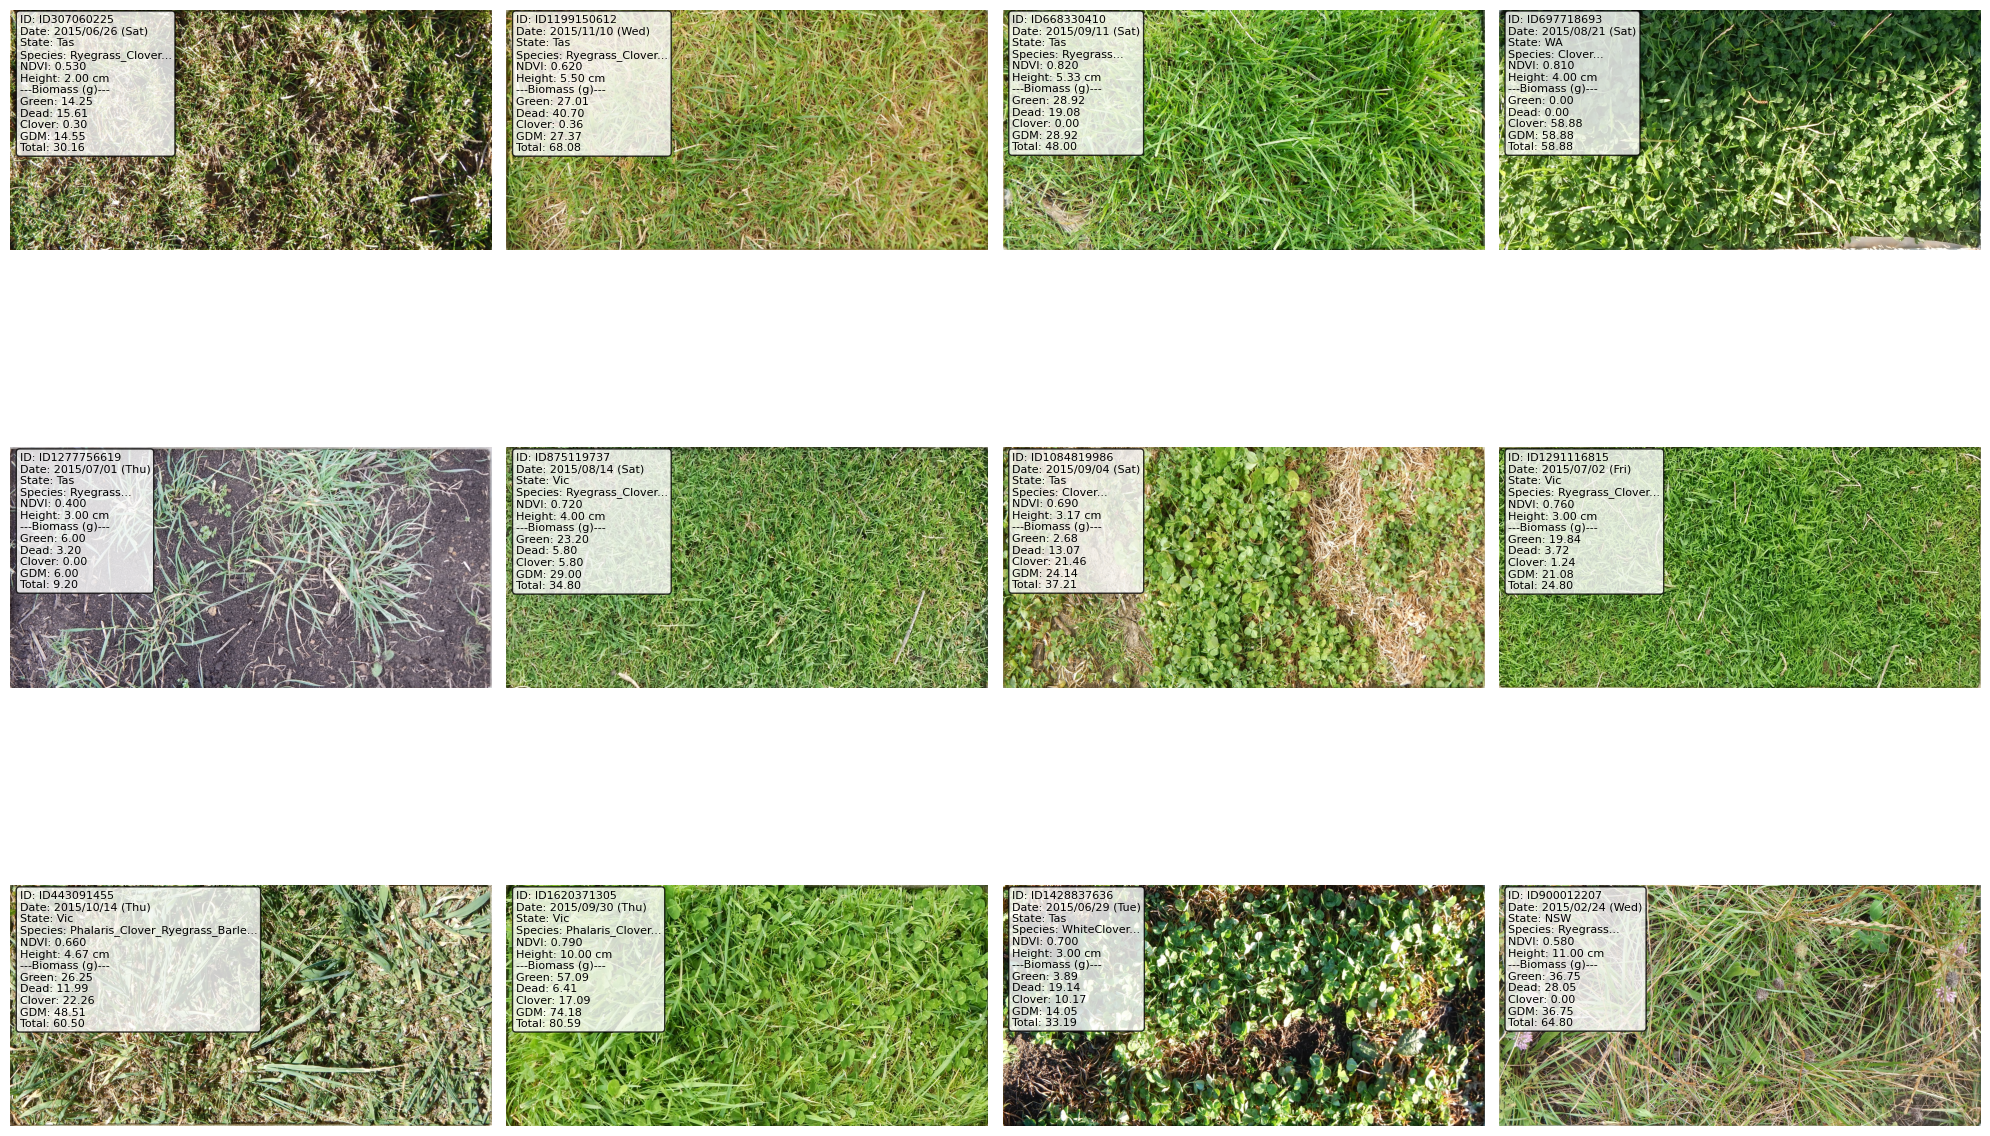

Sample images saved as 'sample_images_with_metadata.png'


In [15]:
# 2-4. 画像とメタデータの可視化 (4列×3行)
print("\n=== Visualizing sample images with metadata ===")

# PandasのDataFrameに変換(可視化用)
train_pivot_pd = train_pivot_df.to_pandas()

# ランダムに12サンプルを選択
np.random.seed(config.seed)
sample_indices = np.random.choice(len(train_pivot_pd), size=min(12, len(train_pivot_pd)), replace=False)
sample_data = train_pivot_pd.iloc[sample_indices]

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, (ax, (_, row)) in enumerate(zip(axes, sample_data.iterrows())):
    # 画像を読み込み
    img_path = config.data_dir / row['image_path']
    
    if img_path.exists():
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        
        # メタデータを表示
        info_text = (
            f"ID: {row['image_id']}\n"
            f"Date: {row['year']}/{row['month']:02d}/{row['day']:02d} ({row['weekday_name']})\n"
            f"State: {row['State']}\n"
            f"Species: {row['Species'][:30]}...\n"
            f"NDVI: {row['Pre_GSHH_NDVI']:.3f}\n"
            f"Height: {row['Height_Ave_cm']:.2f} cm\n"
            f"---Biomass (g)---\n"
            f"Green: {row['Dry_Green_g']:.2f}\n"
            f"Dead: {row['Dry_Dead_g']:.2f}\n"
            f"Clover: {row['Dry_Clover_g']:.2f}\n"
            f"GDM: {row['GDM_g']:.2f}\n"
            f"Total: {row['Dry_Total_g']:.2f}"
        )
        
        ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_images_with_metadata.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample images saved as 'sample_images_with_metadata.png'")

# 3: データ分析と可視化

Session 3: Data Analysis and Visualization

=== Biomass Distribution Analysis ===


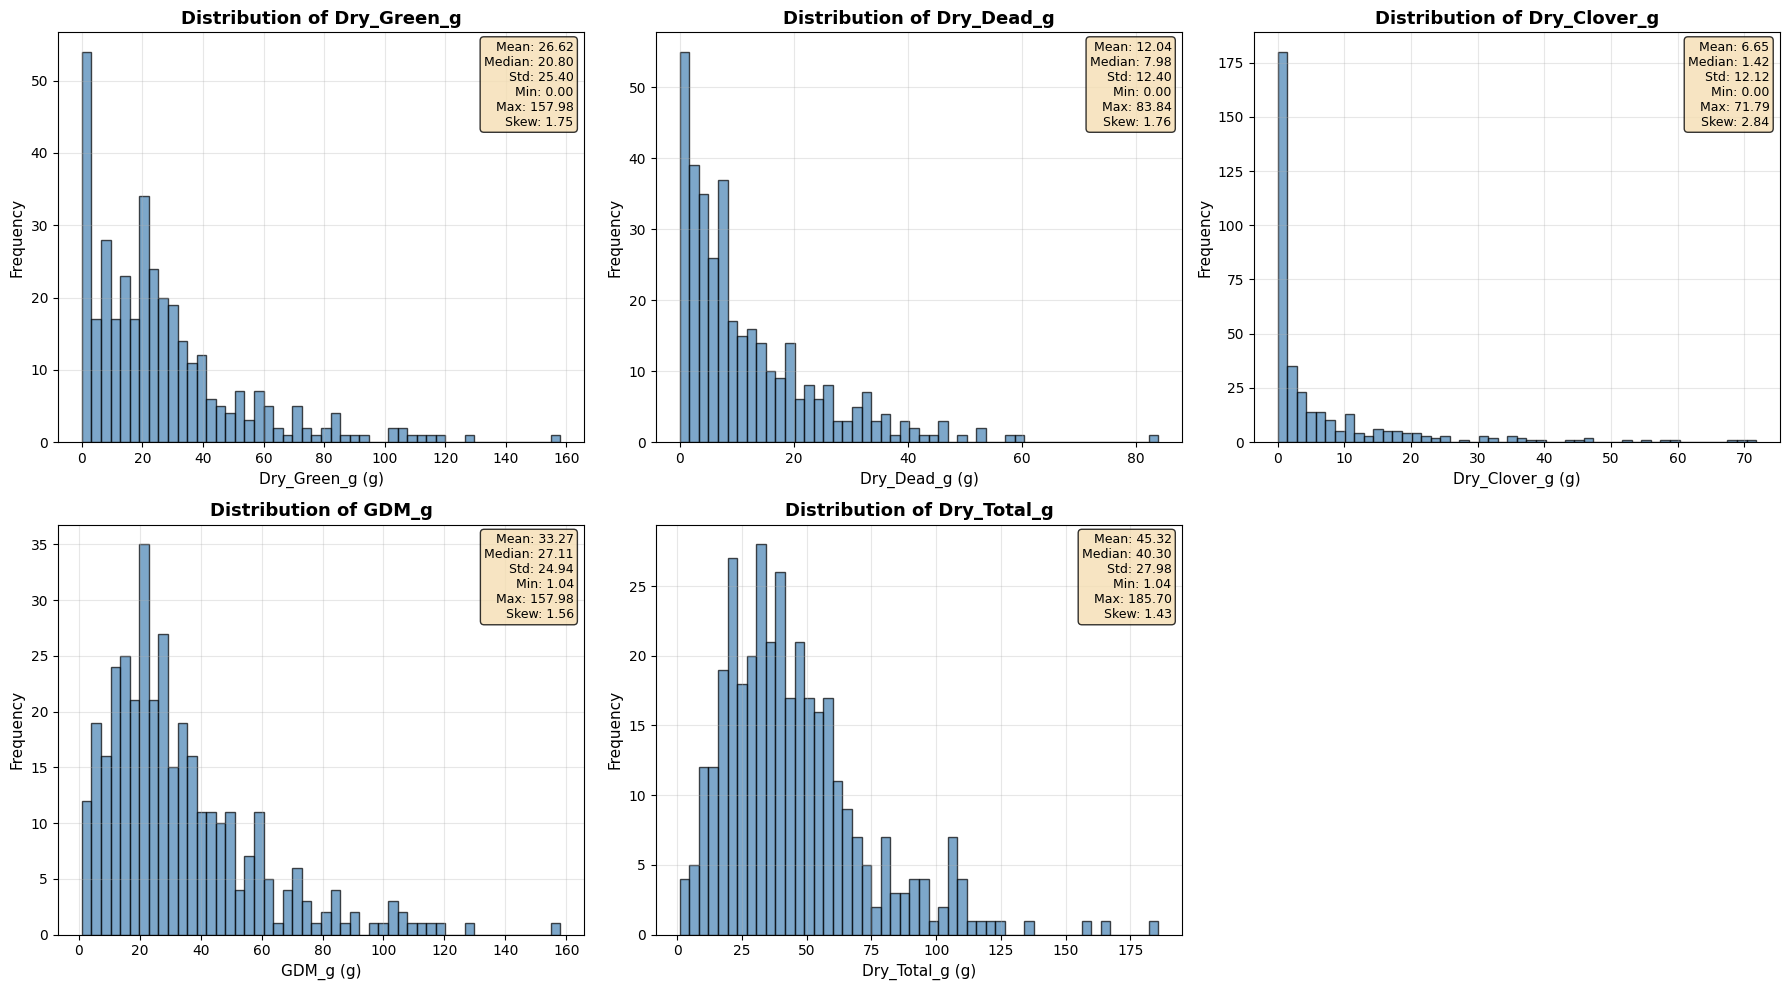

Biomass distribution plot saved as 'biomass_distributions.png'


In [16]:
sep("Session 3: Data Analysis and Visualization")

# PandasのDataFrameに変換(可視化用)
train_pivot_pd = train_pivot_df.to_pandas()

# 3-1. バイオマス成分ごとの分布を可視化
print("\n=== Biomass Distribution Analysis ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, target_col in enumerate(config.target_cols):
    ax = axes[idx]
    data = train_pivot_pd[target_col].dropna()
    
    # ヒストグラム
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
    ax.set_xlabel(f'{target_col} (g)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'Distribution of {target_col}', fontsize=13, fontweight='bold')
    
    # 統計情報を追加
    stats_text = (
        f"Mean: {data.mean():.2f}\n"
        f"Median: {data.median():.2f}\n"
        f"Std: {data.std():.2f}\n"
        f"Min: {data.min():.2f}\n"
        f"Max: {data.max():.2f}\n"
        f"Skew: {data.skew():.2f}"
    )
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.grid(True, alpha=0.3)

# 最後のサブプロットを削除
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('biomass_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Biomass distribution plot saved as 'biomass_distributions.png'")


=== Biomass Distribution (Log Scale) ===


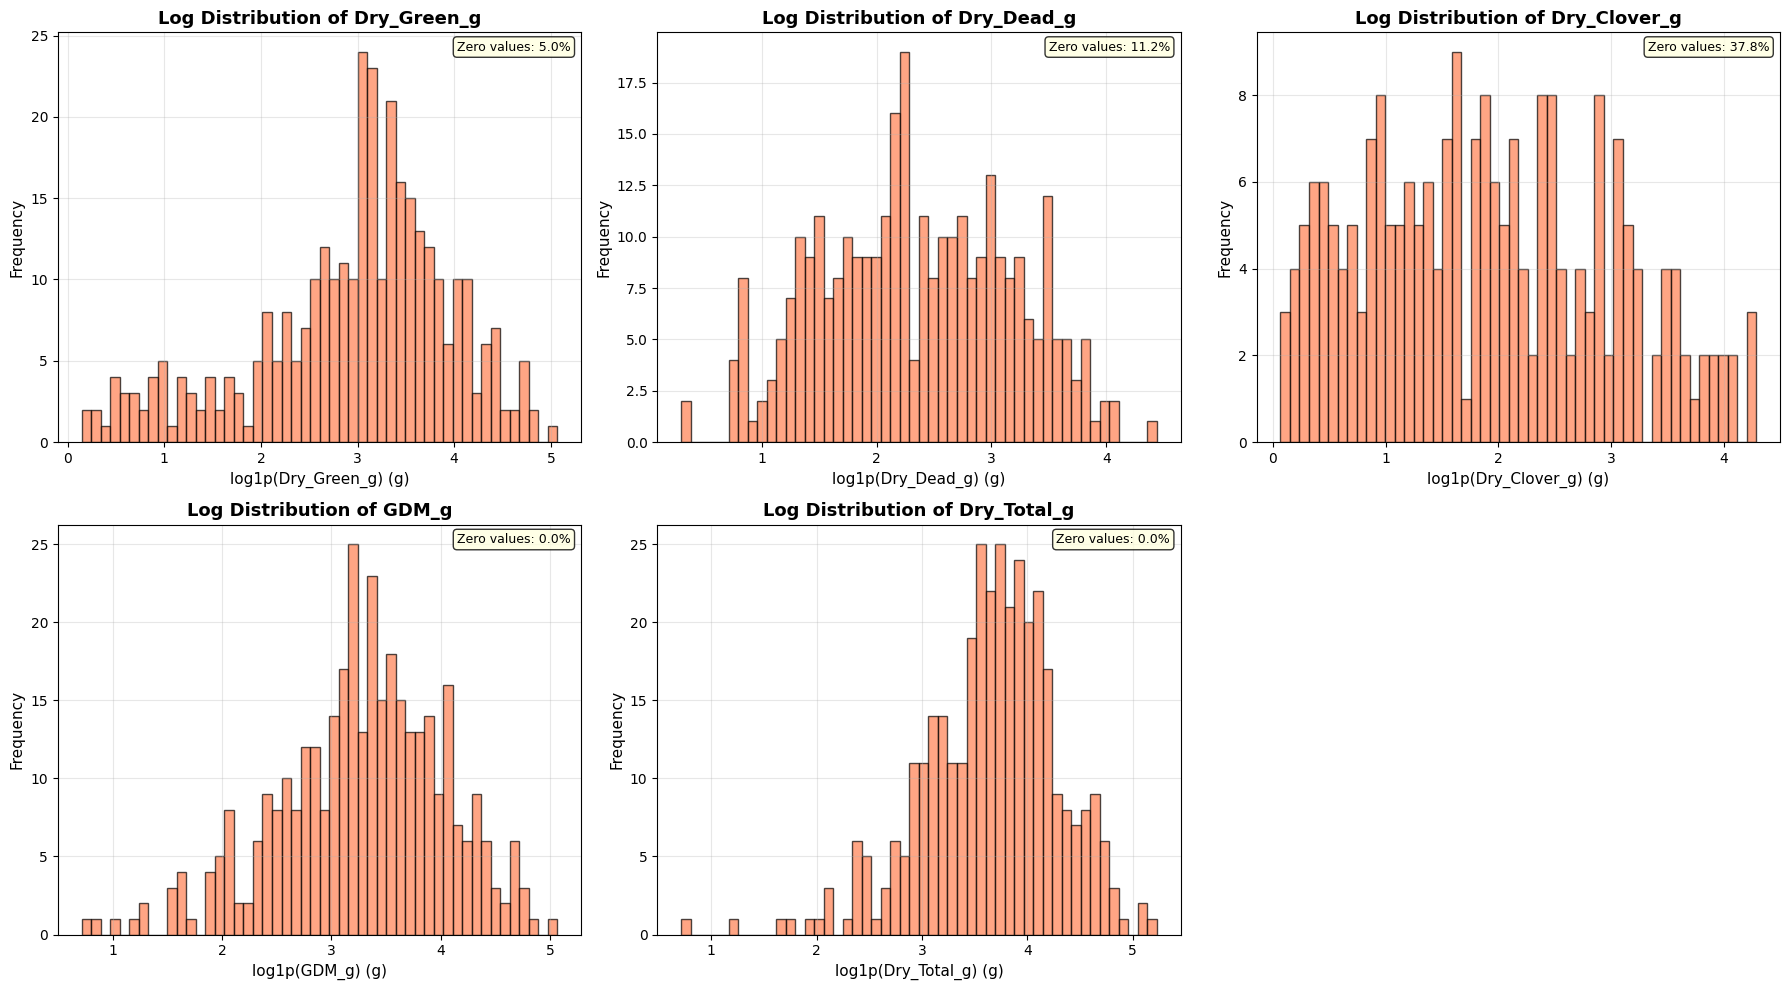

Log distribution plot saved as 'biomass_distributions_log.png'


In [17]:
# 3-2. 対数スケールでの分布も確認
print("\n=== Biomass Distribution (Log Scale) ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, target_col in enumerate(config.target_cols):
    ax = axes[idx]
    # 0より大きい値のみを使用
    data = train_pivot_pd[target_col].dropna()
    data_positive = data[data > 0]
    
    if len(data_positive) > 0:
        ax.hist(np.log1p(data_positive), bins=50, alpha=0.7, edgecolor='black', color='coral')
        ax.set_xlabel(f'log1p({target_col}) (g)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'Log Distribution of {target_col}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # ゼロの割合を表示
        zero_pct = (data == 0).sum() / len(data) * 100
        ax.text(0.98, 0.98, f'Zero values: {zero_pct:.1f}%', 
                transform=ax.transAxes, fontsize=9, 
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

fig.delaxes(axes[-1])
plt.tight_layout()
plt.savefig('biomass_distributions_log.png', dpi=150, bbox_inches='tight')
plt.show()

print("Log distribution plot saved as 'biomass_distributions_log.png'")


=== Feature vs Biomass Scatter Plots ===


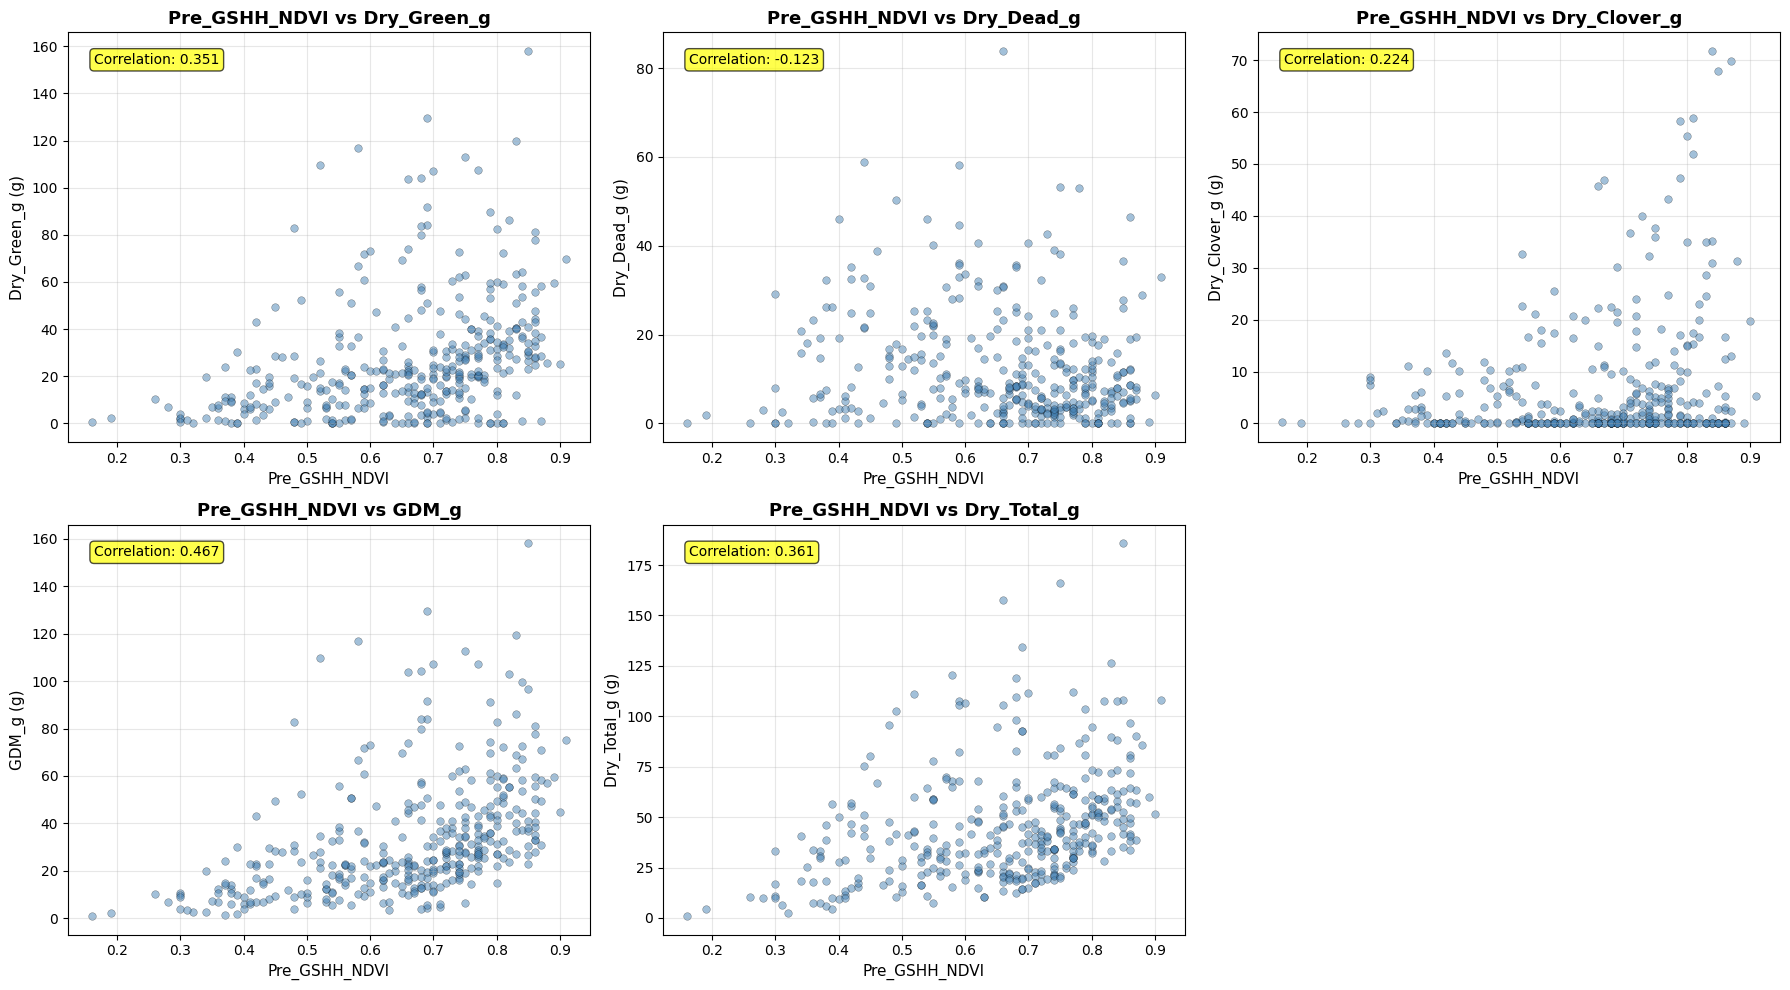

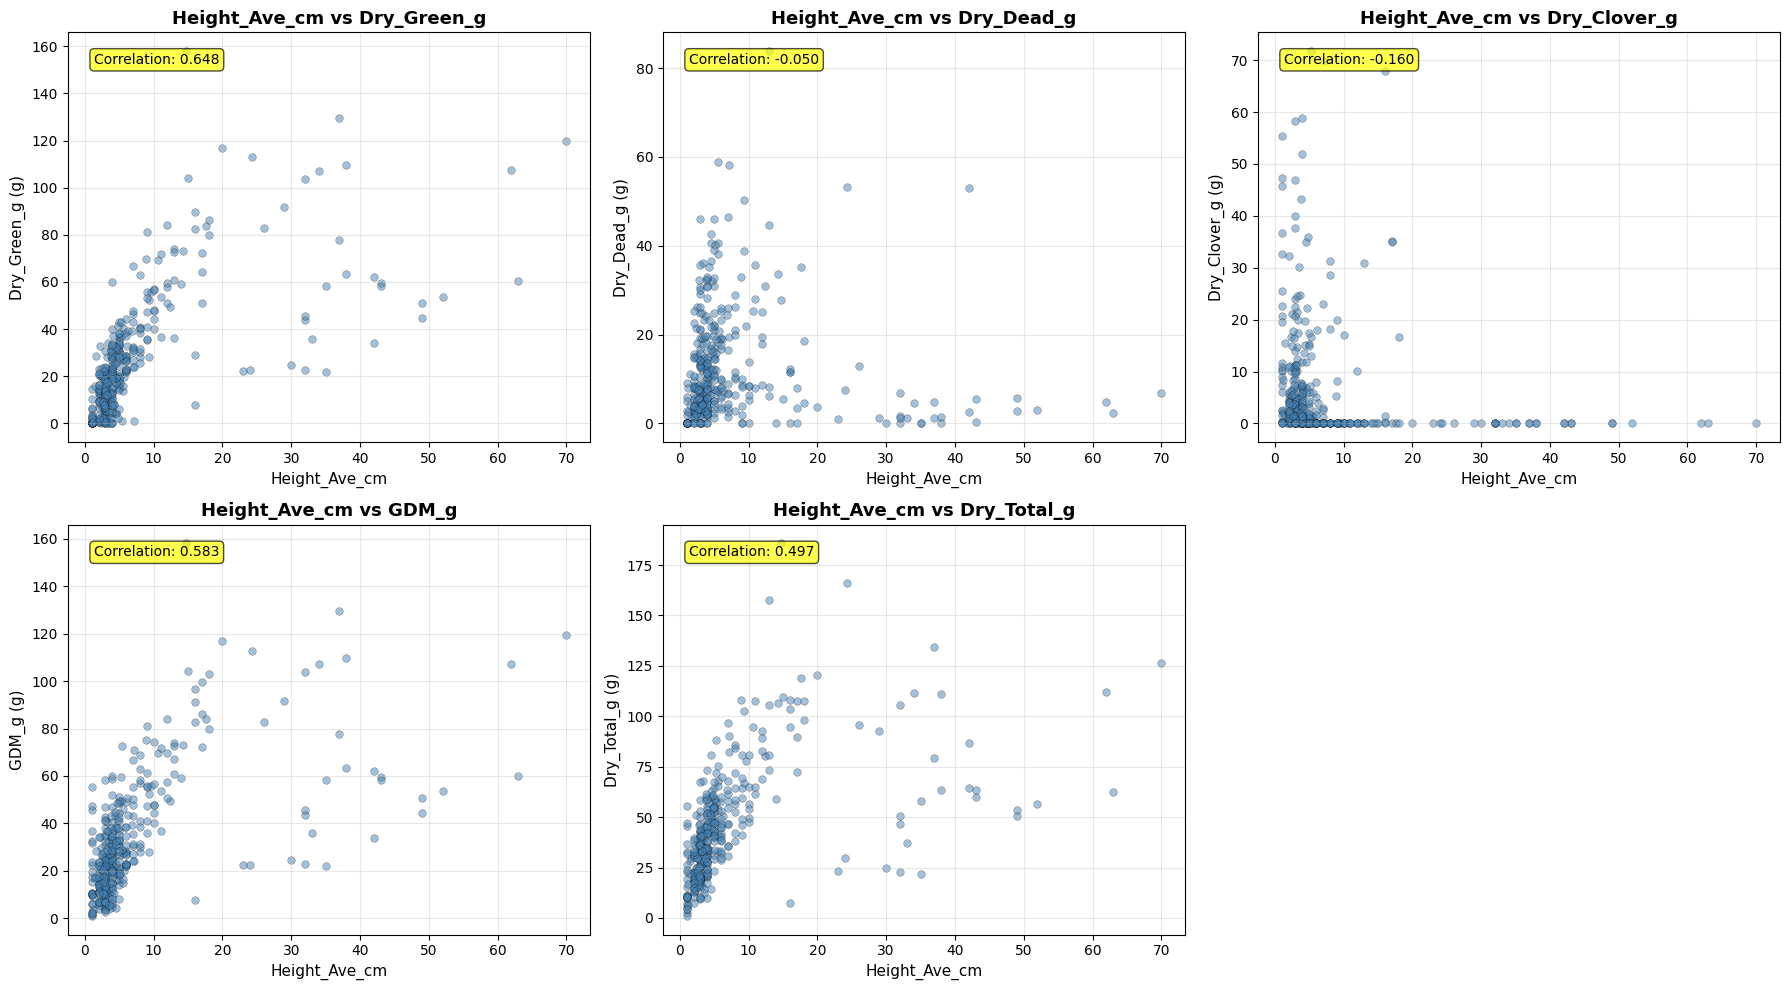

Scatter plots saved


In [18]:
# 3-3. バイオマス値と数値特徴量の関係性を散布図で可視化
print("\n=== Feature vs Biomass Scatter Plots ===")

feature_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm']

for feature in feature_cols:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, target_col in enumerate(config.target_cols):
        ax = axes[idx]
        
        # 散布図
        ax.scatter(train_pivot_pd[feature], train_pivot_pd[target_col], 
                  alpha=0.5, s=30, edgecolors='k', linewidth=0.3, c='steelblue')
        ax.set_xlabel(feature, fontsize=11)
        ax.set_ylabel(f'{target_col} (g)', fontsize=11)
        ax.set_title(f'{feature} vs {target_col}', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # 相関係数を計算して表示
        corr = train_pivot_pd[[feature, target_col]].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    fig.delaxes(axes[-1])
    plt.tight_layout()
    plt.savefig(f'{feature}_vs_biomass.png', dpi=150, bbox_inches='tight')
    plt.show()
    
print("Scatter plots saved")


=== Biomass by State (Box Plot) ===


/tmp/ipykernel_17/3217950068.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)
/tmp/ipykernel_17/3217950068.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)
/tmp/ipykernel_17/3217950068.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)
/tmp/ipykernel_17/3217950068.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped 

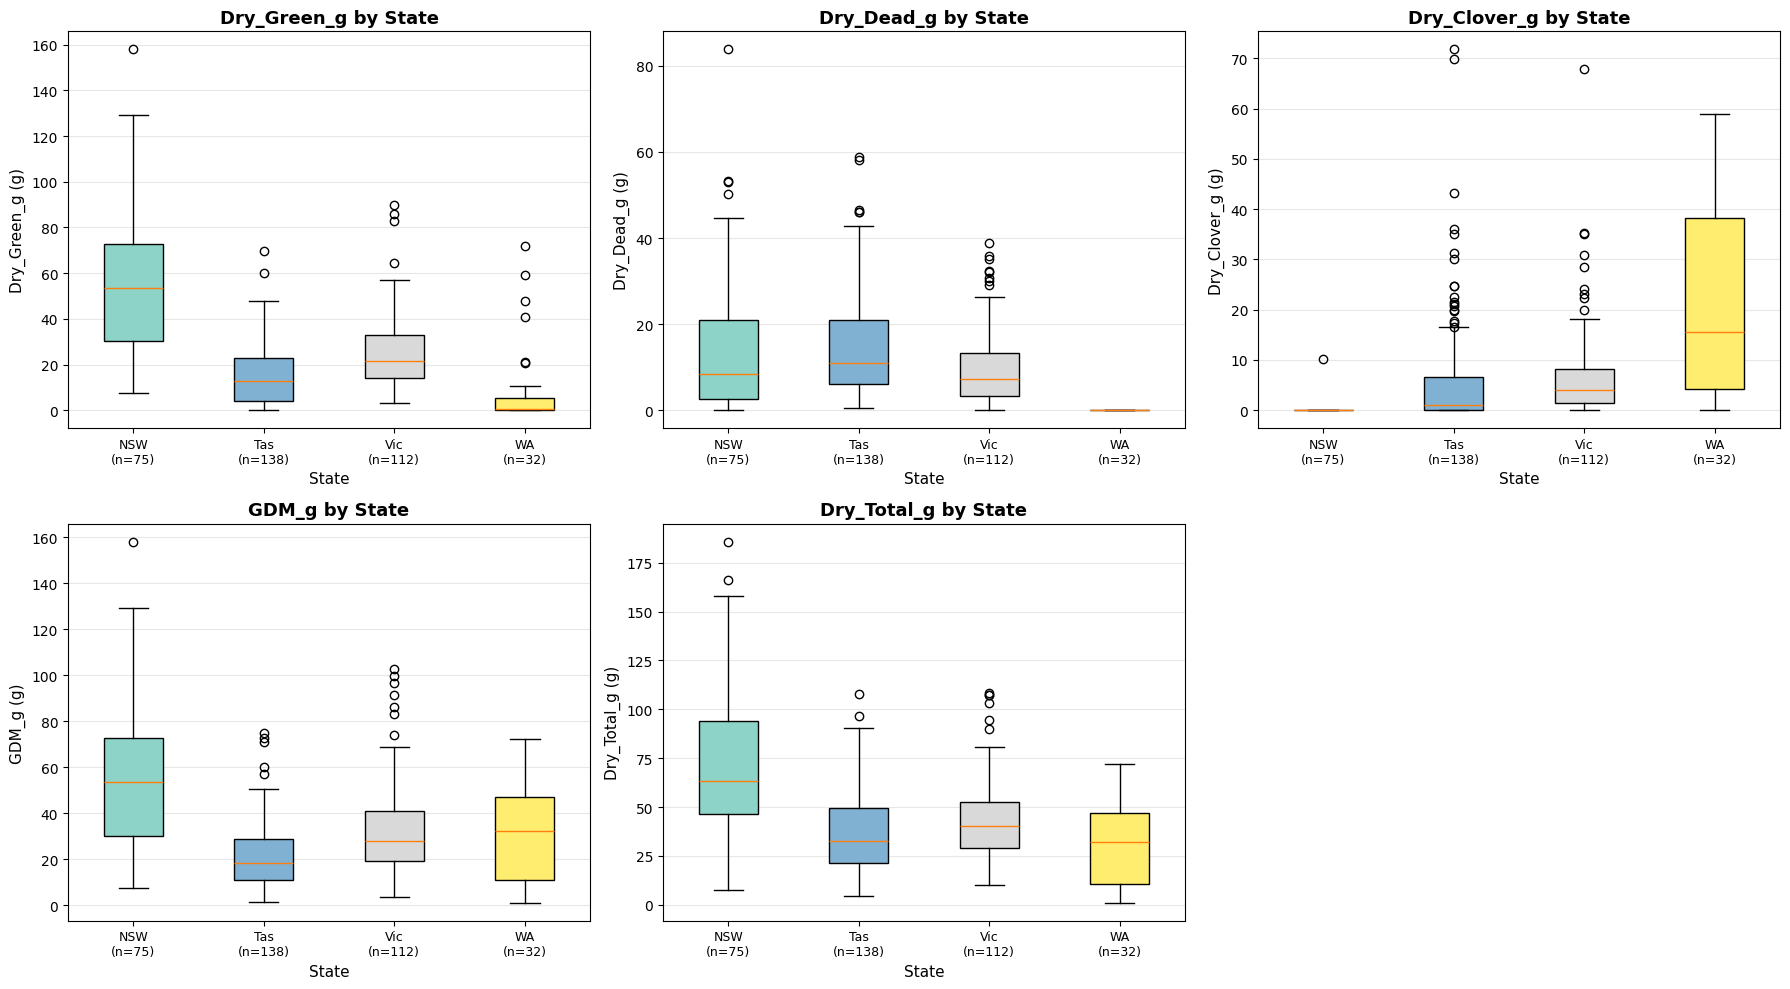

Biomass by state plot saved


In [19]:
# 3-4. 箱ひげ図で州ごとの違いを可視化
print("\n=== Biomass by State (Box Plot) ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

states_sorted = sorted(train_pivot_pd['State'].unique())

for idx, target_col in enumerate(config.target_cols):
    ax = axes[idx]
    
    # 州ごとのデータを準備
    plot_data = []
    labels = []
    for state in states_sorted:
        state_data = train_pivot_pd[train_pivot_pd['State'] == state][target_col].dropna()
        if len(state_data) > 0:
            plot_data.append(state_data)
            labels.append(f'{state}\n(n={len(state_data)})')
    
    # 箱ひげ図
    bp = ax.boxplot(plot_data, labels=labels, patch_artist=True)
    
    # 色を付ける
    colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xlabel('State', fontsize=11)
    ax.set_ylabel(f'{target_col} (g)', fontsize=11)
    ax.set_title(f'{target_col} by State', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize=9)

fig.delaxes(axes[-1])
plt.tight_layout()
plt.savefig('biomass_by_state.png', dpi=150, bbox_inches='tight')
plt.show()

print("Biomass by state plot saved")


=== Biomass by Month (Seasonal Pattern) ===


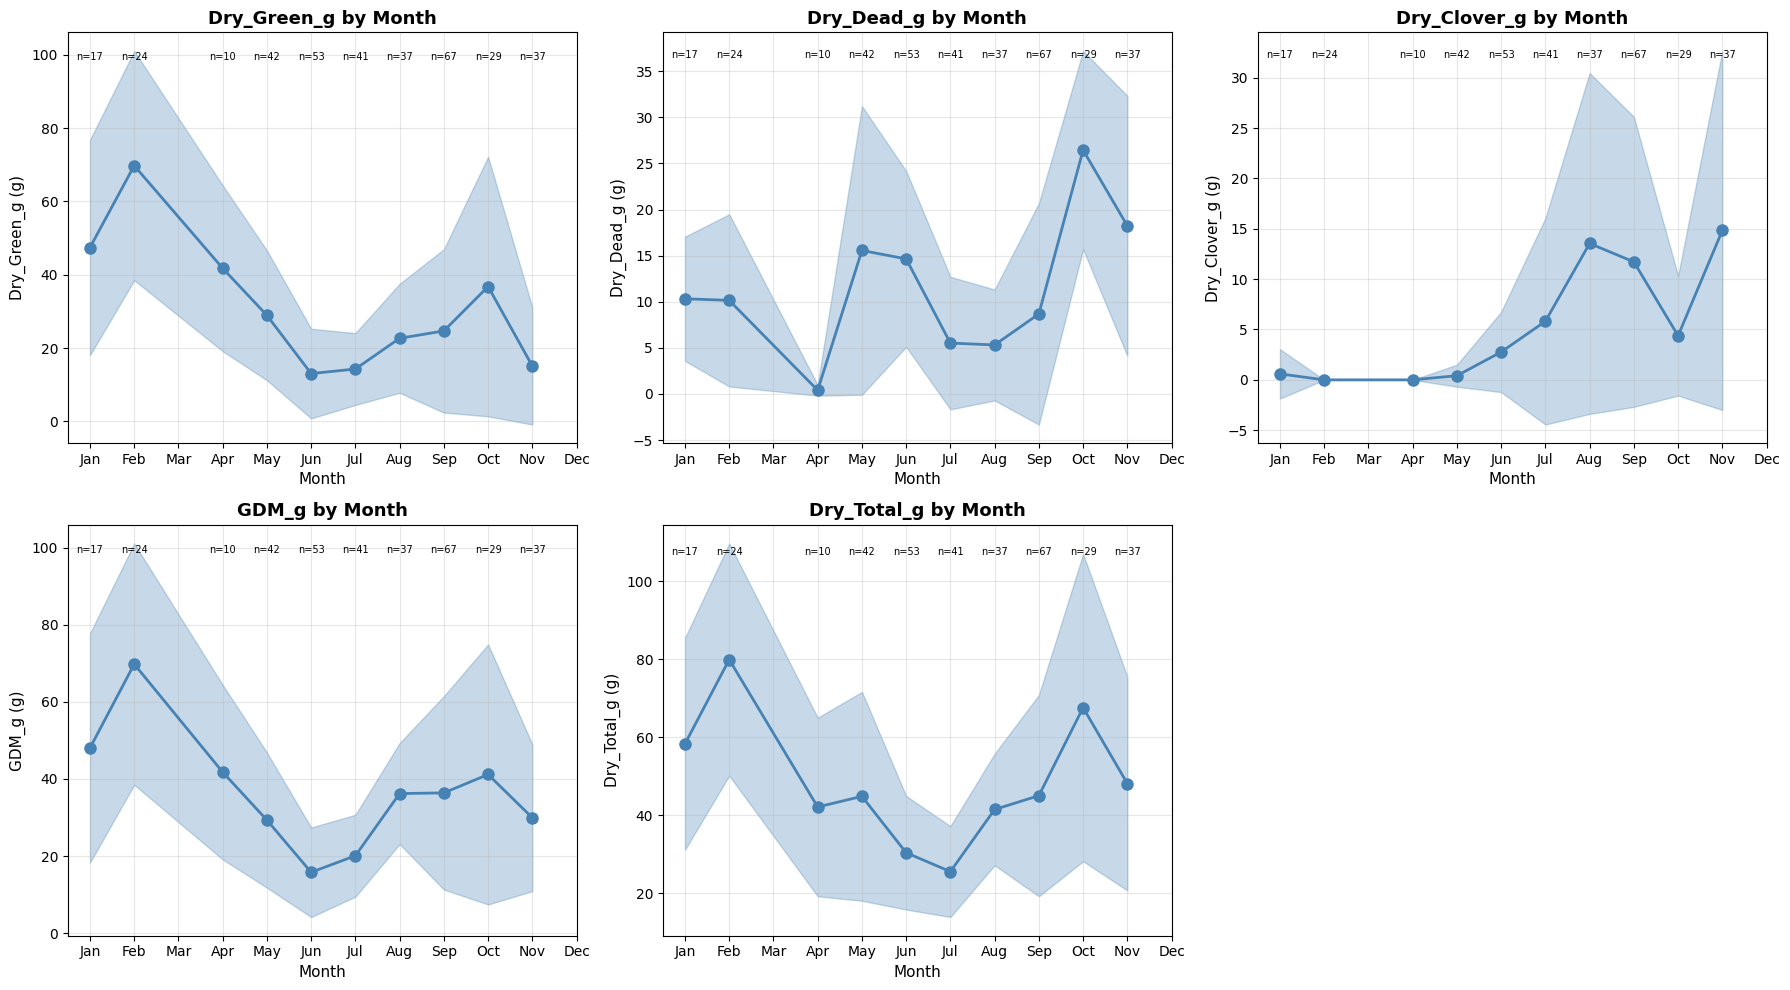

Biomass by month plot saved


In [20]:
# 3-5. 月ごとの季節性を確認
print("\n=== Biomass by Month (Seasonal Pattern) ===")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, target_col in enumerate(config.target_cols):
    ax = axes[idx]
    
    # 月ごとの平均と標準偏差
    monthly_stats = train_pivot_pd.groupby('month')[target_col].agg(['mean', 'std', 'count'])
    
    months = monthly_stats.index
    means = monthly_stats['mean']
    stds = monthly_stats['std']
    
    # 折れ線グラフとエラーバー
    ax.plot(months, means, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax.fill_between(months, means - stds, means + stds, alpha=0.3, color='steelblue')
    
    ax.set_xlabel('Month', fontsize=11)
    ax.set_ylabel(f'{target_col} (g)', fontsize=11)
    ax.set_title(f'{target_col} by Month', fontsize=13, fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid(True, alpha=0.3)
    
    # サンプル数を表示
    for month, count in zip(months, monthly_stats['count']):
        ax.text(month, ax.get_ylim()[1] * 0.95, f'n={int(count)}', 
                ha='center', va='top', fontsize=7, rotation=0)

fig.delaxes(axes[-1])
plt.tight_layout()
plt.savefig('biomass_by_month.png', dpi=150, bbox_inches='tight')
plt.show()

print("Biomass by month plot saved")


=== Correlation Matrix (Numerical Features) ===


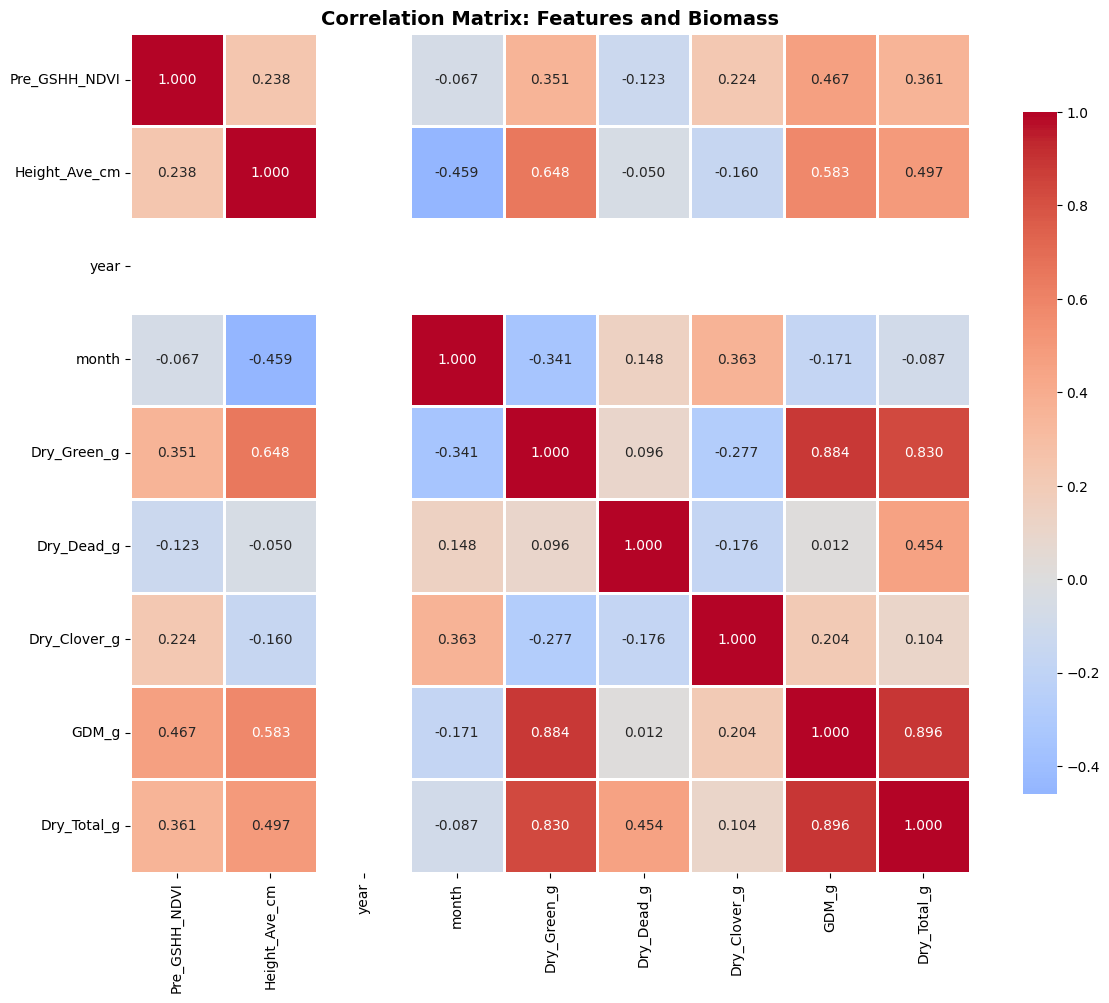


=== Correlation with Dry_Total_g ===
Dry_Total_g      1.000000
GDM_g            0.896441
Dry_Green_g      0.830315
Height_Ave_cm    0.497226
Dry_Dead_g       0.453912
Pre_GSHH_NDVI    0.361291
Dry_Clover_g     0.104185
month           -0.086853
year                  NaN
Name: Dry_Total_g, dtype: float64


In [21]:
# 3-6. 相関行列を計算して可視化
print("\n=== Correlation Matrix (Numerical Features) ===")

# 数値列のみを選択
numeric_cols = ['Pre_GSHH_NDVI', 'Height_Ave_cm', 'year', 'month'] + config.target_cols
corr_matrix = train_pivot_pd[numeric_cols].corr()

# ヒートマップで可視化
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Features and Biomass', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== Correlation with Dry_Total_g ===")
total_corr = corr_matrix['Dry_Total_g'].sort_values(ascending=False)
print(total_corr)


=== Species Co-occurrence Analysis ===

Top 10 species combinations:
                                              Species  count
11                                    Ryegrass_Clover     98
10                                           Ryegrass     62
7                                     Phalaris_Clover     42
0                                              Clover     41
1                                              Fescue     28
3                                             Lucerne     22
6   Phalaris_BarleyGrass_SilverGrass_SpearGrass_Cl...     11
2                                    Fescue_CrumbWeed     10
14                                        WhiteClover     10
9                            Phalaris_Ryegrass_Clover      8


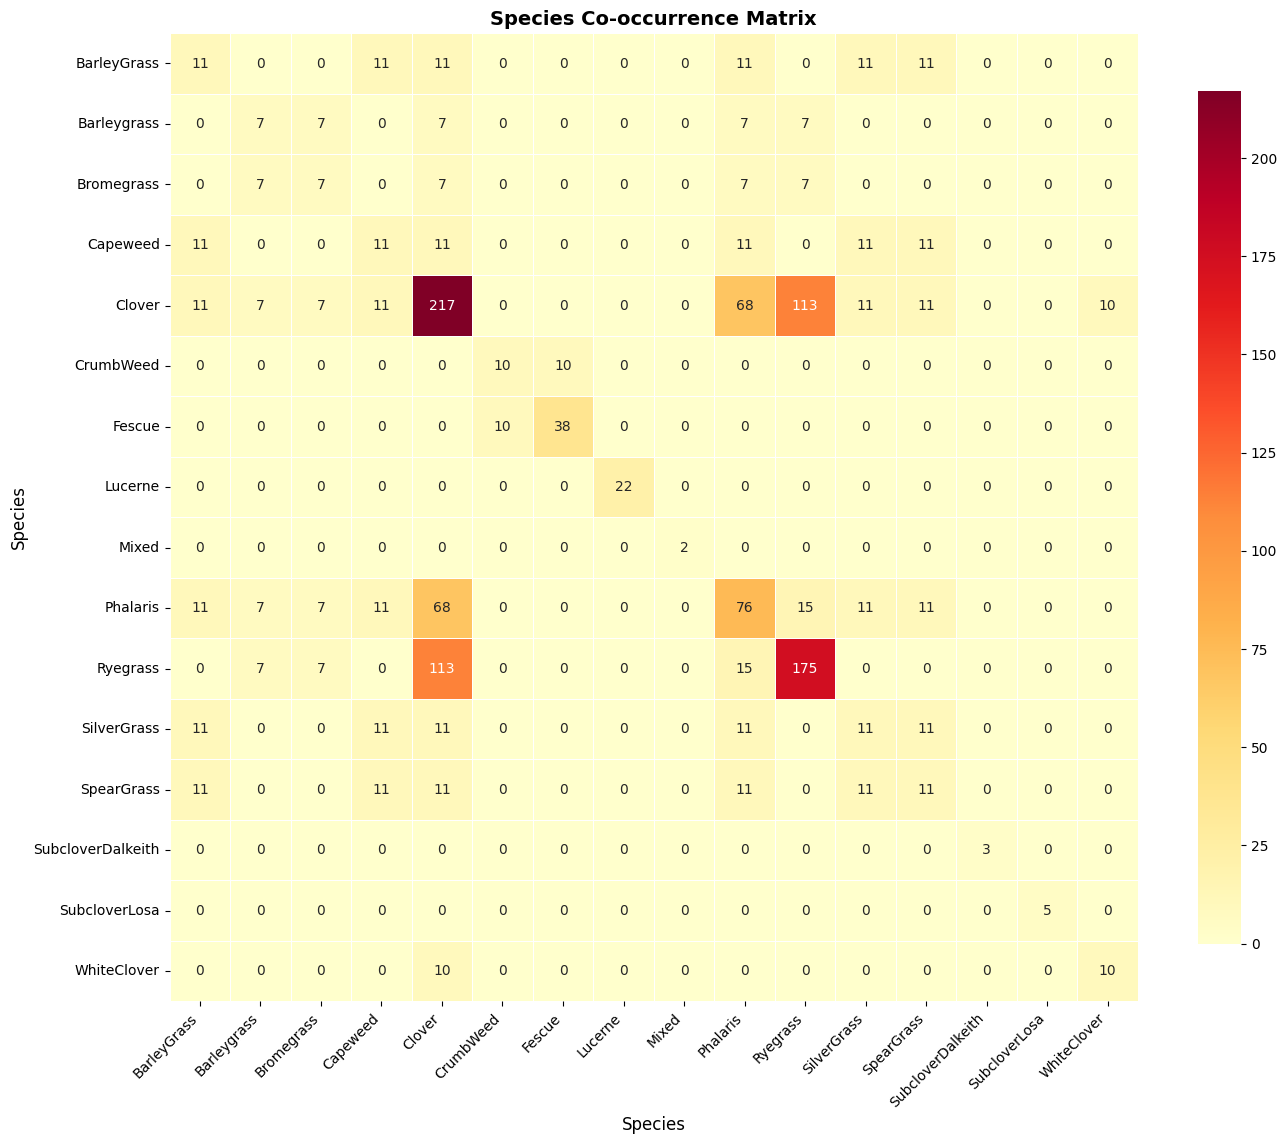

Species co-occurrence matrix saved


In [22]:
# 3-7. 種の共起パターンを可視化
print("\n=== Species Co-occurrence Analysis ===")

# 種の組み合わせパターンを集計
species_combination_counts = train_pivot_pd.groupby('Species').size().reset_index(name='count')
species_combination_counts = species_combination_counts.sort_values('count', ascending=False)

print("\nTop 10 species combinations:")
print(species_combination_counts.head(10))

# 種の共起行列を作成
species_df = train_pivot_pd[config.species_cols].astype(int)
cooccurrence_matrix = species_df.T.dot(species_df)

# ヒートマップで可視化
plt.figure(figsize=(14, 12))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='g', cmap='YlOrRd', 
            xticklabels=config.all_species, yticklabels=config.all_species,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Species Co-occurrence Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Species', fontsize=12)
plt.ylabel('Species', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('species_cooccurrence.png', dpi=150, bbox_inches='tight')
plt.show()

print("Species co-occurrence matrix saved")



=== Species Frequency ===


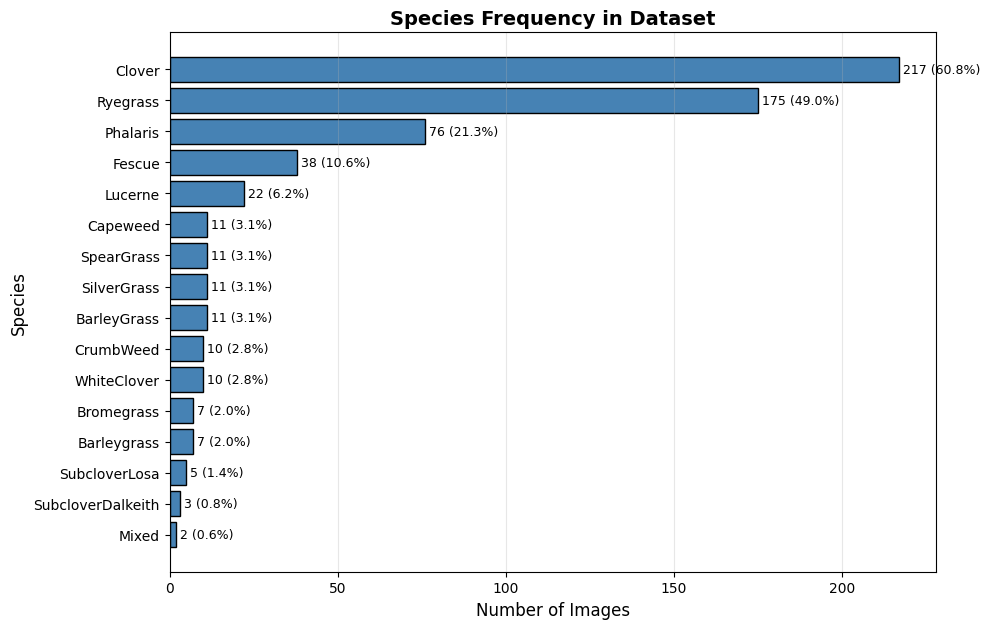

Species frequency plot saved


In [23]:
# 3-8. 各種の出現頻度を可視化
print("\n=== Species Frequency ===")

species_freq = {}
for species in config.all_species:
    count = train_pivot_pd[f'is_{species}'].sum()
    species_freq[species] = count

# 横棒グラフで可視化
species_freq_df = pd.DataFrame(list(species_freq.items()), columns=['Species', 'Count'])
species_freq_df = species_freq_df.sort_values('Count', ascending=True)

plt.figure(figsize=(10, max(6, len(config.all_species) * 0.4)))
bars = plt.barh(species_freq_df['Species'], species_freq_df['Count'], color='steelblue', edgecolor='black')
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Species', fontsize=12)
plt.title('Species Frequency in Dataset', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# パーセンテージを表示
total_images = len(train_pivot_pd)
for i, (species, count) in enumerate(zip(species_freq_df['Species'], species_freq_df['Count'])):
    pct = count / total_images * 100
    plt.text(count, i, f' {count} ({pct:.1f}%)', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('species_frequency.png', dpi=150, bbox_inches='tight')
plt.show()

print("Species frequency plot saved")


=== Biomass by Species Presence (Top Species) ===


/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be

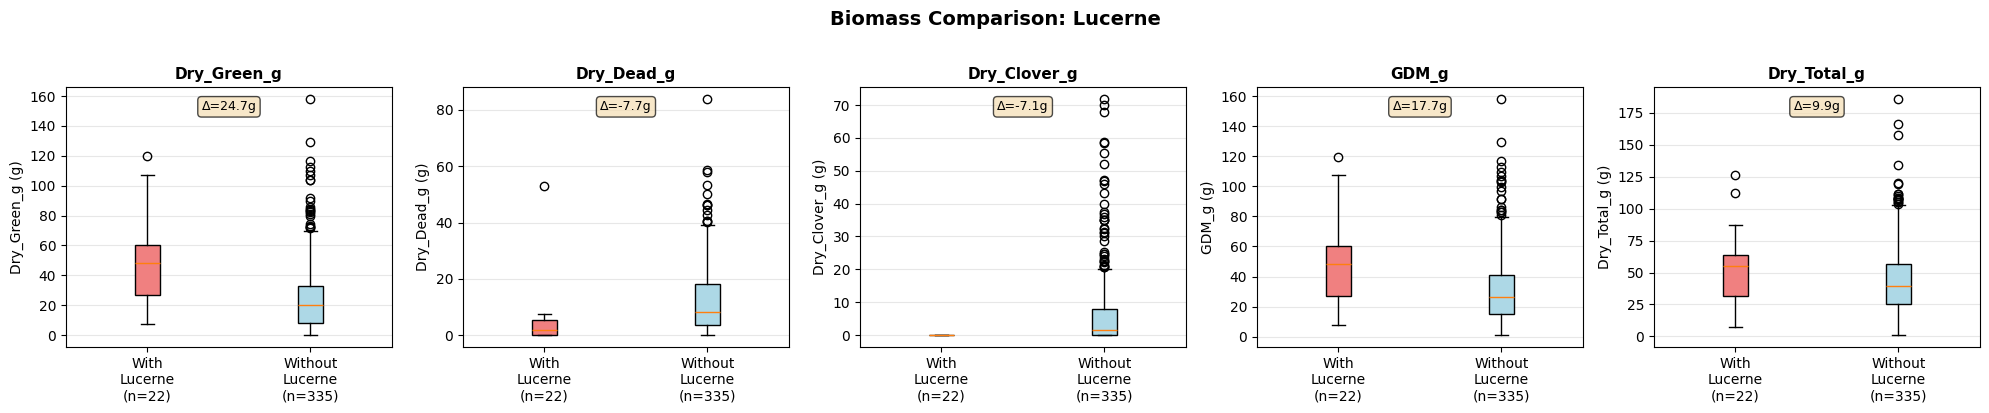

/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be

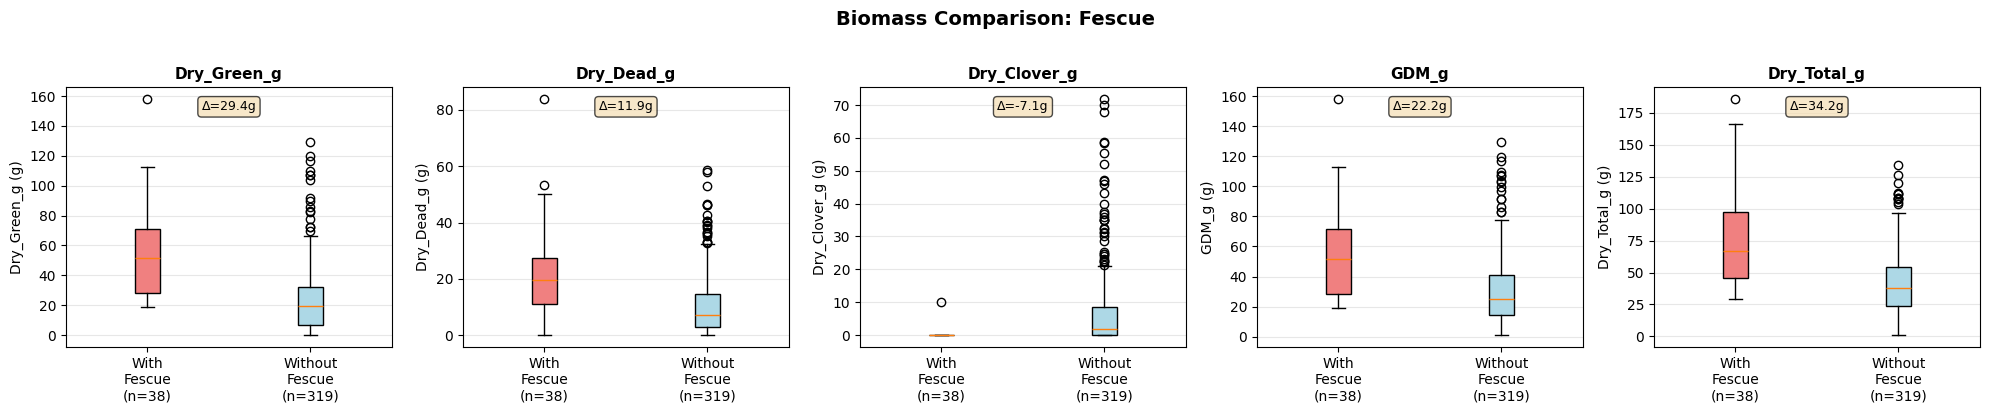

/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be

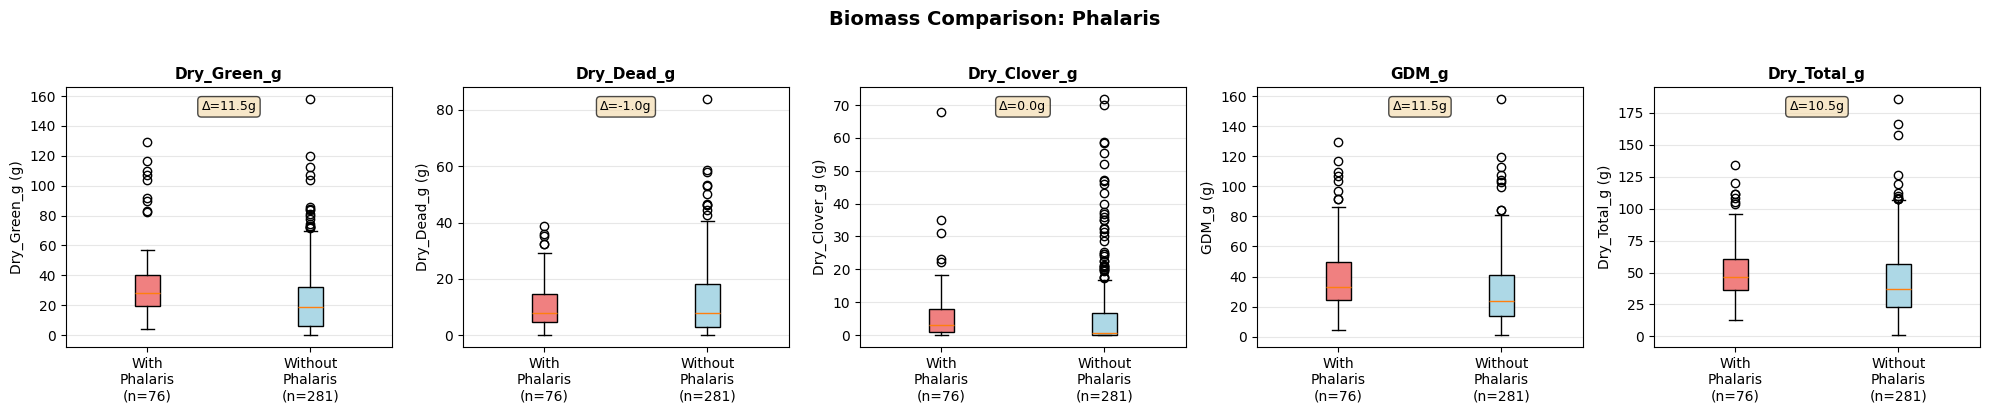

/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be

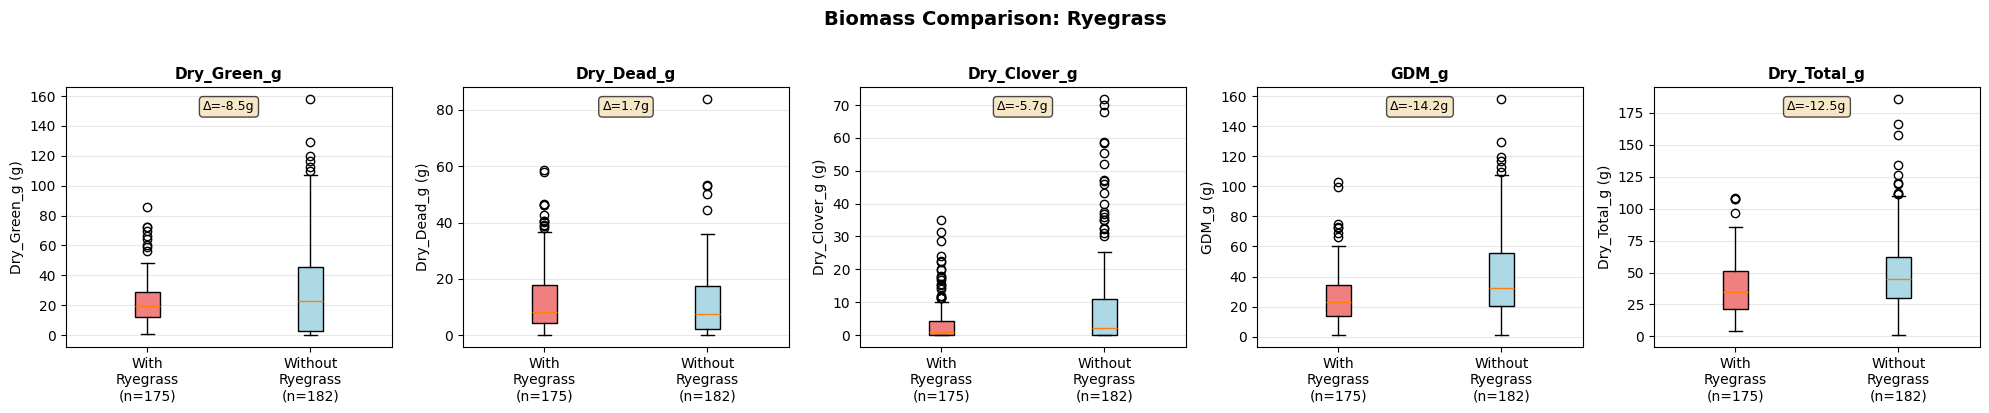

/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
/tmp/ipykernel_17/4141070418.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be

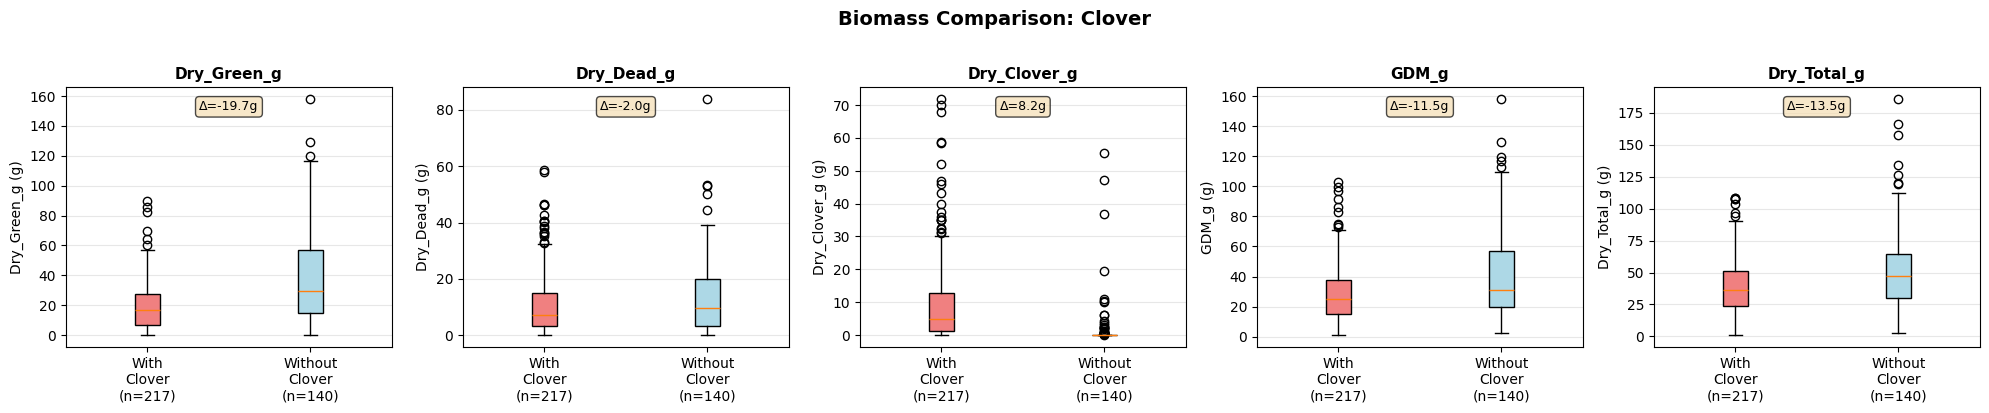

Biomass by species presence plots saved


In [24]:
# 3-9. 種の有無によるバイオマスの違いを可視化（主要な種のみ）
print("\n=== Biomass by Species Presence (Top Species) ===")

# 出現頻度が高い上位5種を選択
top_species = species_freq_df.tail(5)['Species'].tolist()

for species in top_species:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for j, target_col in enumerate(config.target_cols):
        ax = axes[j]
        
        # その種が含まれる/含まれないでデータを分割
        has_species = train_pivot_pd[train_pivot_pd[f'is_{species}']][target_col].dropna()
        no_species = train_pivot_pd[~train_pivot_pd[f'is_{species}']][target_col].dropna()
        
        # 箱ひげ図
        data_to_plot = [has_species, no_species]
        labels = [f'With\n{species}\n(n={len(has_species)})', 
                  f'Without\n{species}\n(n={len(no_species)})']
        
        bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightcoral')
        bp['boxes'][1].set_facecolor('lightblue')
        
        ax.set_ylabel(f'{target_col} (g)', fontsize=10)
        ax.set_title(f'{target_col}', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # 平均値の差を表示
        mean_diff = has_species.mean() - no_species.mean()
        ax.text(0.5, 0.95, f'Δ={mean_diff:.1f}g', transform=ax.transAxes,
                ha='center', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.suptitle(f'Biomass Comparison: {species}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'biomass_by_{species}_presence.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Biomass by species presence plots saved")


=== Statistical Significance Test (t-test) ===

=== Significant differences (p < 0.05) ===
Found 40 significant associations
          species        target       diff    diff_pct       p_value
20         Clover   Dry_Green_g -19.712614  -51.059821  1.142718e-13
34         Fescue   Dry_Total_g  34.171878   81.984788  1.647489e-13
30         Fescue   Dry_Green_g  29.379005  125.030100  3.495130e-12
22         Clover  Dry_Clover_g   8.213357  495.598810  1.347339e-10
31         Fescue    Dry_Dead_g  11.936328  110.788123  1.025718e-08
53       Ryegrass         GDM_g -14.205261  -35.303295  4.164380e-08
33         Fescue         GDM_g  22.234582   71.938632  1.240029e-07
72  SubcloverLosa  Dry_Clover_g  26.004517  413.723429  1.342469e-06
24         Clover   Dry_Total_g -13.529229  -25.268562  6.343411e-06
35        Lucerne   Dry_Green_g  24.748694   98.601972  7.456194e-06
52       Ryegrass  Dry_Clover_g  -5.668993  -60.125438  7.755522e-06
23         Clover         GDM_g -11.499259  -2

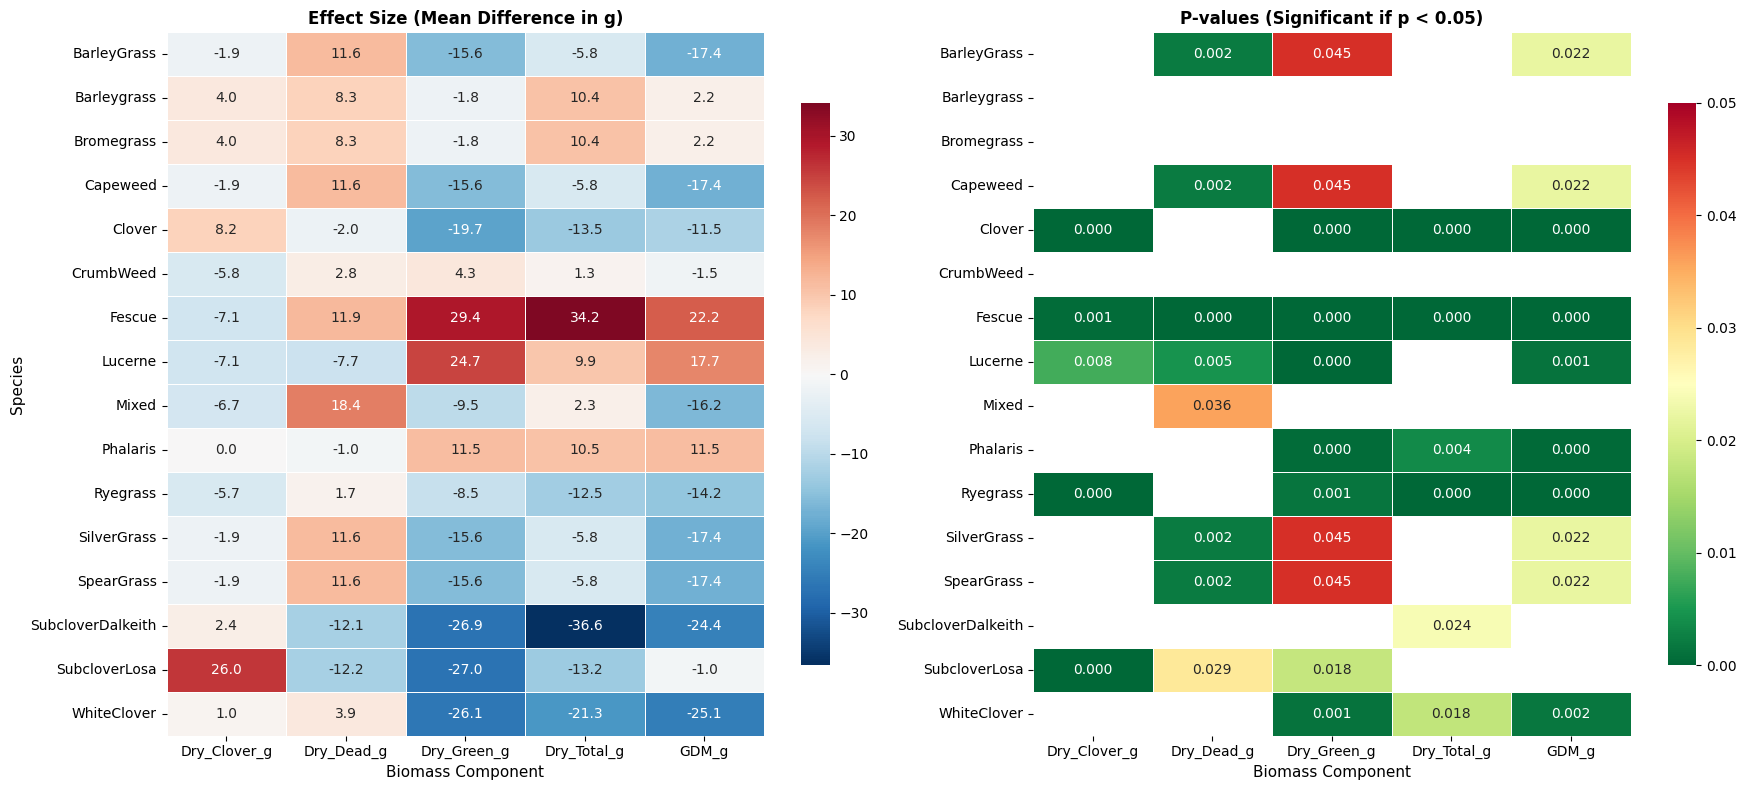

Significance heatmap saved


In [25]:
# 3-10. 統計的検定（t検定）で種の有無による差を確認
print("\n=== Statistical Significance Test (t-test) ===")

from scipy import stats

significance_results = []

for species in config.all_species:
    for target_col in config.target_cols:
        has_species = train_pivot_pd[train_pivot_pd[f'is_{species}']][target_col].dropna()
        no_species = train_pivot_pd[~train_pivot_pd[f'is_{species}']][target_col].dropna()
        
        if len(has_species) > 1 and len(no_species) > 1:
            t_stat, p_value = stats.ttest_ind(has_species, no_species)
            
            significance_results.append({
                'species': species,
                'target': target_col,
                'n_with': len(has_species),
                'n_without': len(no_species),
                'mean_with': has_species.mean(),
                'mean_without': no_species.mean(),
                'diff': has_species.mean() - no_species.mean(),
                'diff_pct': (has_species.mean() - no_species.mean()) / no_species.mean() * 100 if no_species.mean() != 0 else np.nan,
                't_statistic': t_stat,
                'p_value': p_value,
                'significant': p_value < 0.05
            })

significance_df = pd.DataFrame(significance_results).sort_values('p_value')

print("\n=== Significant differences (p < 0.05) ===")
sig_results = significance_df[significance_df['significant']].copy()
print(f"Found {len(sig_results)} significant associations")
print(sig_results[['species', 'target', 'diff', 'diff_pct', 'p_value']].head(20))

# 結果をCSVで保存
significance_df.to_csv('species_biomass_significance.csv', index=False)
print("\nSignificance test results saved as 'species_biomass_significance.csv'")

# 有意な結果をヒートマップで可視化
print("\n=== Heatmap of Significant Associations ===")

# p値を行列形式に変換
pvalue_matrix = significance_df.pivot(index='species', columns='target', values='p_value')
effect_matrix = significance_df.pivot(index='species', columns='target', values='diff')

# 有意性のマスク（p < 0.05）
mask = pvalue_matrix > 0.05

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, max(8, len(config.all_species) * 0.5)))

# 左: 効果量（平均差）
sns.heatmap(effect_matrix, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
            ax=ax1, cbar_kws={"shrink": 0.8}, linewidths=0.5)
ax1.set_title('Effect Size (Mean Difference in g)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Biomass Component', fontsize=11)
ax1.set_ylabel('Species', fontsize=11)

# 右: p値（有意性）
sns.heatmap(pvalue_matrix, annot=True, fmt='.3f', cmap='RdYlGn_r',
            mask=mask, ax=ax2, cbar_kws={"shrink": 0.8}, linewidths=0.5,
            vmin=0, vmax=0.05)
ax2.set_title('P-values (Significant if p < 0.05)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Biomass Component', fontsize=11)
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('species_significance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Significance heatmap saved")


=== Feature Importance Summary ===

Feature importance (correlation or mean difference with Dry_Total_g):
                 Feature  Impact_on_Dry_Total_g
15  is_SubcloverDalkeith             -36.572092
8              is_Fescue              34.171878
17        is_WhiteClover             -21.271775
6              is_Clover             -13.529229
16      is_SubcloverLosa             -13.213155
12           is_Ryegrass             -12.544134
11           is_Phalaris              10.508308
3         is_Barleygrass              10.443827
4          is_Bromegrass              10.443827
9             is_Lucerne               9.949589
14         is_SpearGrass              -5.834226
13        is_SilverGrass              -5.834226
2         is_BarleyGrass              -5.834226
5            is_Capeweed              -5.834226
10              is_Mixed               2.257551
7           is_CrumbWeed               1.267405
1          Height_Ave_cm               0.497226
0          Pre_GSHH_NDVI     

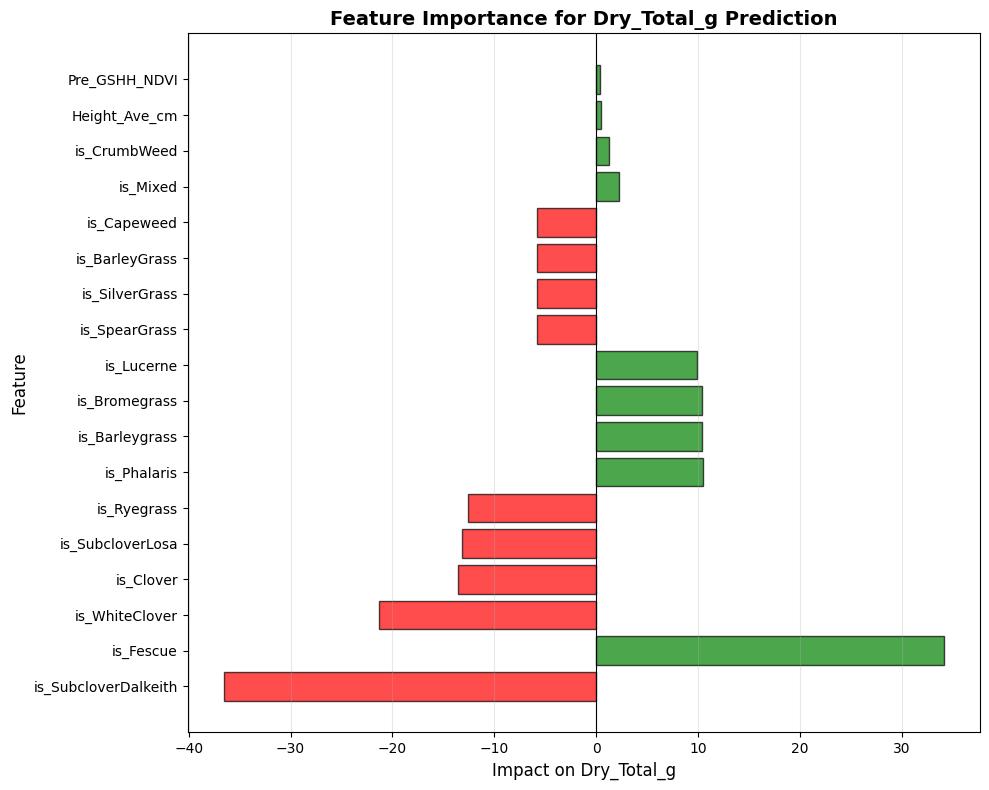

Feature importance plot and CSV saved


In [26]:
# 3-11. 特徴量の重要度サマリー
print("\n=== Feature Importance Summary ===")

feature_importance = {
    'Pre_GSHH_NDVI': corr_matrix.loc['Pre_GSHH_NDVI', 'Dry_Total_g'],
    'Height_Ave_cm': corr_matrix.loc['Height_Ave_cm', 'Dry_Total_g'],
}

# 各種の重要度（Dry_Total_gとの関係）
for species in config.all_species:
    species_sig = significance_df[(significance_df['species'] == species) & 
                                  (significance_df['target'] == 'Dry_Total_g')]
    if len(species_sig) > 0:
        feature_importance[f'is_{species}'] = species_sig.iloc[0]['diff']

# ソートして表示
importance_df = pd.DataFrame(list(feature_importance.items()), 
                            columns=['Feature', 'Impact_on_Dry_Total_g'])
importance_df = importance_df.sort_values('Impact_on_Dry_Total_g', key=abs, ascending=False)

print("\nFeature importance (correlation or mean difference with Dry_Total_g):")
print(importance_df)

# 可視化
plt.figure(figsize=(10, max(8, len(importance_df) * 0.3)))
colors = ['red' if x < 0 else 'green' for x in importance_df['Impact_on_Dry_Total_g']]
plt.barh(importance_df['Feature'], importance_df['Impact_on_Dry_Total_g'], 
         color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Impact on Dry_Total_g', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Dry_Total_g Prediction', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

importance_df.to_csv('feature_importance.csv', index=False)
print("Feature importance plot and CSV saved")

# 4: WandB Upload

In [27]:
sep("Session 4: Upload to WandB")

# ==========================
# WandB初期化
# ==========================
run = wandb.init(
    project=config.wandb_project,
    entity=config.wandb_entity,
    group=BASE_GROUP,
    job_type="data-upload-and-visualization",
    name=f"full-pipeline-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    config={
        "dataset": "csimo-dataset",
        "purpose": "データ可視化",
        "upload_date": datetime.now().isoformat(),
        "use_polars": True,
        "seed": config.seed,
        "visualization_samples": config.num_visualization_samples,
        "generate_html_report": config.generate_html_report,
    },
    tags=["EDA", "biomass", "pasture"]
)

print(f"WandB Run URL: {run.url}")
print(f"WandB Group: {BASE_GROUP}")
print(f"設定:")
print(f"  - 可視化サンプル数: {config.num_visualization_samples}")
print(f"  - HTMLレポート: {config.generate_html_report}")
print()

Session 4: Upload to WandB


wandb: Currently logged in as: hidebu to https://toyota.wandb.io. Use `wandb login --relogin` to force relogin
wandb: setting up run 3u0e5t1a
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251225_021352-3u0e5t1a
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run full-pipeline-20251225-021351
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/csiro-biomass
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/csiro-biomass/runs/3u0e5t1a


WandB Run URL: https://toyota.wandb.io/hidebu/csiro-biomass/runs/3u0e5t1a
WandB Group: lc-sample-20251225-021314
設定:
  - 可視化サンプル数: 500
  - HTMLレポート: True



In [28]:
# 4-1. 画像とメタデータをWandBテーブルにアップロード
print("\n=== Creating WandB Table with Images ===")

# サンプル数を制限（全データをアップロードする場合は調整）
n_samples = min(200, len(train_pivot_pd))
sample_indices = np.random.choice(len(train_pivot_pd), size=n_samples, replace=False)
sample_data = train_pivot_pd.iloc[sample_indices]

# WandBテーブル用の列を定義
columns = ['image_id', 'image', 'date', 'year', 'month', 'day', 'weekday_name', 
           'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'] + config.target_cols + config.species_cols

wandb_table = wandb.Table(columns=columns)

print(f"Uploading {n_samples} samples to WandB...")
for _, row in tqdm(sample_data.iterrows(), total=len(sample_data), desc="Creating table"):
    img_path = config.data_dir / row['image_path']
    
    if img_path.exists():
        # WandB Imageオブジェクトを作成
        wandb_img = wandb.Image(str(img_path))
        
        # 行データを準備
        row_data = [
            row['image_id'],
            wandb_img,
            f"{row['year']}/{row['month']:02d}/{row['day']:02d}",
            int(row['year']),
            int(row['month']),
            int(row['day']),
            row['weekday_name'],
            row['State'],
            row['Species'][:60],  # 長すぎる場合は切り詰め
            float(row['Pre_GSHH_NDVI']),
            float(row['Height_Ave_cm']),
        ]
        
        # バイオマス値を追加
        for target_col in config.target_cols:
            row_data.append(float(row[target_col]))
        
        # Species One-hot特徴量を追加
        for species_col in config.species_cols:
            row_data.append(bool(row[species_col]))
        
        wandb_table.add_data(*row_data)

# テーブルをログ
wandb.log({"training_data_with_species": wandb_table})
print(f"✓ Uploaded {n_samples} samples to WandB table")


=== Creating WandB Table with Images ===
Uploading 200 samples to WandB...


Creating table: 100%|██████████| 200/200 [00:18<00:00, 10.87it/s]


✓ Uploaded 200 samples to WandB table


In [29]:
# 4-2. サマリー統計をテーブルでアップロード
print("\n=== Uploading Summary Statistics ===")

# バイオマスの統計情報
biomass_stats = train_pivot_pd[config.target_cols].describe().T
biomass_stats['target'] = biomass_stats.index
biomass_stats = biomass_stats.reset_index(drop=True)
wandb.log({"biomass_statistics": wandb.Table(dataframe=biomass_stats)})
print("✓ Biomass statistics uploaded")

# 種の出現頻度
species_freq_table = species_freq_df.copy()
species_freq_table['percentage'] = species_freq_table['Count'] / len(train_pivot_pd) * 100
wandb.log({"species_frequency": wandb.Table(dataframe=species_freq_table)})
print("✓ Species frequency uploaded")

# 州別サンプル数
state_counts = train_pivot_pd['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']
wandb.log({"state_distribution": wandb.Table(dataframe=state_counts)})
print("✓ State distribution uploaded")

# 月別サンプル数
month_counts = train_pivot_pd['month'].value_counts().sort_index().reset_index()
month_counts.columns = ['Month', 'Count']
wandb.log({"month_distribution": wandb.Table(dataframe=month_counts)})
print("✓ Month distribution uploaded")


=== Uploading Summary Statistics ===
✓ Biomass statistics uploaded
✓ Species frequency uploaded
✓ State distribution uploaded
✓ Month distribution uploaded


In [30]:
# 4-3. 相関行列をアップロード
print("\n=== Uploading Correlation Matrix ===")
corr_matrix_reset = corr_matrix.reset_index()
corr_matrix_reset.rename(columns={'index': 'Feature'}, inplace=True)
wandb.log({"correlation_matrix_table": wandb.Table(dataframe=corr_matrix_reset)})
print("✓ Correlation matrix uploaded")

# 4-4. 有意性検定結果をアップロード
print("\n=== Uploading Statistical Test Results ===")
wandb.log({"species_biomass_significance": wandb.Table(dataframe=significance_df)})
print("✓ Statistical significance test results uploaded")

# 4-5. 特徴量重要度をアップロード
wandb.log({"feature_importance": wandb.Table(dataframe=importance_df)})
print("✓ Feature importance uploaded")


=== Uploading Correlation Matrix ===
✓ Correlation matrix uploaded

=== Uploading Statistical Test Results ===
✓ Statistical significance test results uploaded
✓ Feature importance uploaded


In [31]:
# 4-6. 可視化画像をアップロード
print("\n=== Uploading Visualization Images ===")

visualization_files = [
    'sample_images_with_metadata.png',
    'biomass_distributions.png',
    'biomass_distributions_log.png',
    'correlation_matrix.png',
    'biomass_by_state.png',
    'biomass_by_month.png',
    'Pre_GSHH_NDVI_vs_biomass.png',
    'Height_Ave_cm_vs_biomass.png',
    'species_cooccurrence.png',
    'species_frequency.png',
    'species_significance_heatmap.png',
    'feature_importance.png',
]

# 種別のバイオマス比較画像も追加
for species in top_species:
    visualization_files.append(f'biomass_by_{species}_presence.png')

uploaded_count = 0
for viz_file in visualization_files:
    if os.path.exists(viz_file):
        wandb.log({viz_file.replace('.png', ''): wandb.Image(viz_file)})
        uploaded_count += 1

print(f"✓ Uploaded {uploaded_count} visualization images")

# 4-7. 統計情報をメトリクスとしてログ
print("\n=== Logging Summary Metrics ===")

# バイオマスの統計
for target_col in config.target_cols:
    data = train_pivot_pd[target_col].dropna()
    wandb.log({
        f"biomass/{target_col}_mean": data.mean(),
        f"biomass/{target_col}_median": data.median(),
        f"biomass/{target_col}_std": data.std(),
        f"biomass/{target_col}_min": data.min(),
        f"biomass/{target_col}_max": data.max(),
        f"biomass/{target_col}_skew": data.skew(),
    })

# 相関の要約
wandb.log({
    "correlation/NDVI_vs_Dry_Total": corr_matrix.loc['Pre_GSHH_NDVI', 'Dry_Total_g'],
    "correlation/Height_vs_Dry_Total": corr_matrix.loc['Height_Ave_cm', 'Dry_Total_g'],
})

# データセット情報
wandb.log({
    "dataset/n_images": len(train_pivot_pd),
    "dataset/n_species": len(config.all_species),
    "dataset/n_states": train_pivot_pd['State'].nunique(),
    "dataset/n_months": train_pivot_pd['month'].nunique(),
    "dataset/significant_associations": len(sig_results),
})

print("✓ Summary metrics logged")

# 4-8. Artifactsとしてデータを保存
print("\n=== Saving Artifacts ===")

# 処理済みのデータを保存
train_pivot_pd.to_csv('train_pivot_processed.csv', index=False)
artifact = wandb.Artifact('processed_data', type='dataset')
artifact.add_file('train_pivot_processed.csv')
run.log_artifact(artifact)
print("✓ Processed training data saved as artifact")

# 統計結果も保存
artifact_stats = wandb.Artifact('statistics', type='analysis')
artifact_stats.add_file('species_biomass_significance.csv')
artifact_stats.add_file('feature_importance.csv')
run.log_artifact(artifact_stats)
print("✓ Statistical results saved as artifact")


=== Uploading Visualization Images ===
✓ Uploaded 17 visualization images

=== Logging Summary Metrics ===
✓ Summary metrics logged

=== Saving Artifacts ===
✓ Processed training data saved as artifact
✓ Statistical results saved as artifact


In [32]:
# WandB runを終了
wandb.finish()
sep("All Sessions Complete!")

wandb: uploading artifact statistics; updating run metadata
wandb: uploading history steps 7-31, summary, console lines 23-33
wandb: 
wandb: Run history:
wandb:    biomass/Dry_Clover_g_max ▁
wandb:   biomass/Dry_Clover_g_mean ▁
wandb: biomass/Dry_Clover_g_median ▁
wandb:    biomass/Dry_Clover_g_min ▁
wandb:   biomass/Dry_Clover_g_skew ▁
wandb:    biomass/Dry_Clover_g_std ▁
wandb:      biomass/Dry_Dead_g_max ▁
wandb:     biomass/Dry_Dead_g_mean ▁
wandb:   biomass/Dry_Dead_g_median ▁
wandb:      biomass/Dry_Dead_g_min ▁
wandb:                         +27 ...
wandb: 
wandb: Run summary:
wandb:    biomass/Dry_Clover_g_max 71.7865
wandb:   biomass/Dry_Clover_g_mean 6.64969
wandb: biomass/Dry_Clover_g_median 1.4235
wandb:    biomass/Dry_Clover_g_min 0
wandb:   biomass/Dry_Clover_g_skew 2.84198
wandb:    biomass/Dry_Clover_g_std 12.11776
wandb:      biomass/Dry_Dead_g_max 83.8407
wandb:     biomass/Dry_Dead_g_mean 12.04455
wandb:   biomass/Dry_Dead_g_median 7.9809
wandb:      biomass/Dry_Dead

All Sessions Complete!
